### Implementation of Mistic 
to our binary description of patient data

In [1]:
import os
starting_directory = os.getcwd()
print(os.getcwd())

/blue/ferrallm/mcremer/cardiac-amyloidosis


### libraries and dirrectories

In [2]:
#set dirrectory
import os
starting_directory = os.getcwd()

#helps when fetching the functions and classes from mistic  
# new_dirrectory = 'C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Shared-From-DrK/mistic_breast_cancer_example/mistic_breast_cancer_example'
new_dirrectory = '/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma'
os.chdir(new_dirrectory)



In [3]:
# Import packages/modules
import matplotlib.pyplot as plt   
plt.rcParams.update({'font.size': 8})

import numpy as np
import pandas as pd

from statistics import mean 
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from seaborn import clustermap, heatmap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel

# Import functions
from mistic_v1 import greedy_backward_selection, tuneSVM, compute_SV_feature_importance, compute_counterfactuals #, compute_SV_feature_contribution
from mistic_v1 import compute_SV_gradient_rank2, compute_SV_importance_rank, compute_SV_contribution_rank, compute_SV_decision_perturbation

In [4]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.calibration import calibration_curve
from scipy.stats import pearsonr
from mistic_v1 import rank_items

class SV_combined_rank():

    def __init__(self,weight=0.5):
        self.weight = weight

    def compute(self,svc,X,y):
        contribution_rank = compute_SV_contribution_rank(svc,X,y)
        importance_rank = compute_SV_importance_rank(svc,X,y)

        consensus_rank = self.weight*contribution_rank + (1-self.weight)*importance_rank
        rank = rank_items(consensus_rank)
        
        return rank

class svc_score():

    def __init__(self, weight=0.5):
        self.weight = weight

    def score(self,svc,X,y):
        y_pred = svc.predict(X)
        
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

        if (tp+fp) > 0:
            precision = tp/(tp+fp)
        else:
            precision = 0
            
        if (tp+fn) > 0:
            recall = tp/(tp+fn)
        else:
            recall = 0
        
        if (precision+recall) > 0:
            f1 = 2*precision*recall/(precision+recall)
        else:
            f1 = 0
            
        auc = roc_auc_score(y, svc.decision_function(X))
        score = self.weight*auc + (1-self.weight)*f1
            
        return pd.DataFrame(data={'f1': f1, 'auc': auc, 'score': score},index=[0])


In [5]:
import shap
from mistic_v1 import compute_SV_integrated_gradient

In [6]:
import plotly.express as px
from seaborn import pairplot, load_dataset

In [7]:
import numpy as np
import pickle

In [8]:
#some functions I wrote to help with exporting data
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

### importing our data

In [9]:
#consider changing dirrectory back to a space to save your data that isn't the mistic folder

# new_dirrectory = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/SVM_Mistic_Output_2024-07-12_v2"
# os.chdir(new_dirrectory)

#for file outputs
fileName_header = "top60E_EchoAdj_240821_Red01_" #what data did you put in
fileName_common = "_Mistic_" #what was performed on the data, for figures, this may be added to
fileName_suffix = "_2024-08-21_v1" #date and versioning

# saving_dirrectory = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/"
saving_dirrectory = "012 Processed Data"
makingFolder = makeFolderPathForData(parent_dir= saving_dirrectory, folderName_header= "SVM_Mistic_top60E_EchoAdj_240821_Red01_", folderName_common= "2024-08-21_", 
                                     folderName_suffix= "v1")
dataFrameFolderOut =  makingFolder #"SVM_Mistic_Output_2024-07-19_v2"
pickleFolderOut = makingFolder

figDirectory = "012 Processed Data"
figFolder = makingFolder #"SVM_Mistic_Output_2024-07-19_v2"



In [10]:
#file name for inputs
#file full with directory
# fileInput_directory = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/DFsForSVM_top60labs_2024-07-26_v1/AL-KnownPts-top60Labs-wFill-Fits-One_2024-07-26_v1.xlsx"
# "C:\Users\maega\Documents\3000 PhD\3300_BEAT Labs\Projects\Cardiac-Amyloidosis-Multiple-Myeloma\012 Processed Data\DFsForSVM_top60labs_2024-07-26_v1"
fileInput_directory = 'AL-KnownPts_EchoAdjLabs_top60E_1Sheet_2024-08-20_v2.xlsx'

In [11]:
# # Import dataset

dataTable = pd.read_excel(fileInput_directory, header = 0)
dataTable

,DeID,Amyloid Status,Dx,Sex,Age,Survival (in months),ALT Result(U/L) Desc count,ALT Result(U/L) Desc mean,ALT Result(U/L) Desc std,ALT Result(U/L) Desc min,...,ChemoTx,ChemoTx Number,ImmunoTx,ImmunoTx Number,HemeTx,HemeTx Number,RadTx,RadTx Number,OtherTx,OtherTx Number
0,B-02,2,1,0,48,9.466667,10,20.500000,6.770032,13,...,0,0,0,0,0,0,0,0,0,0
1,C-03,2,2,1,59,17.000000,12,51.916667,16.144002,27,...,1,2,0,0,0,0,0,0,0,0
2,E-01,2,1,0,50,71.300000,121,23.702479,16.060119,8,...,0,0,0,0,0,0,0,0,0,0
3,E-02,2,1,0,64,20.466667,4,35.500000,7.937254,28,...,0,0,0,0,0,0,0,0,0,0
4,F-03,2,2,0,61,52.000000,7,7.285714,1.253566,6,...,1,4,0,0,1,1,0,0,0,0
5,G-01,2,2,0,70,104.000000,49,32.795918,20.225788,13,...,0,0,1,1,0,0,0,0,0,0
6,G-02,2,2,1,36,30.000000,33,15.060606,4.084570,7,...,0,0,0,0,0,0,0,0,0,0
7,I-01,2,2,1,55,33.000000,50,24.920000,11.078274,13,...,1,4,1,2,0,0,0,0,0,0
8,I-03,2,1,0,67,10.033333,13,57.923077,33.023884,24,...,0,0,0,0,0,0,0,0,0,0
9,J-02,2,2,1,68,26.000000,9,30.333333,14.000000,15,...,1,1,1,1,0,0,0,0,0,0


In [12]:
#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'Amyloid Status']


#columns to use for the y data 
y_column_Classification = 'Amyloid Status'

### scale data

In [13]:
# Scale input X
X = dataTable.copy()
X.drop(columns= x_columns_toDrop,inplace=True)
scaler = StandardScaler()
scaler.fit(X) #computes the mean and STD along the features axis

X_train_all = scaler.transform(X) #standardization by centering and scaling
y_train_all = dataTable[y_column_Classification]
X_train_all

array([[-0.74270874, -0.77459667, -1.52139307, ..., -0.14586499,
        -0.20851441, -0.20851441],
       [ 0.8072921 ,  1.29099445, -0.40879537, ..., -0.14586499,
        -0.20851441, -0.20851441],
       [-0.74270874, -0.77459667, -1.31910258, ..., -0.14586499,
        -0.20851441, -0.20851441],
       ...,
       [-0.74270874, -0.77459667,  0.90609283, ..., -0.14586499,
        -0.20851441, -0.20851441],
       [ 0.8072921 , -0.77459667, -0.40879537, ..., -0.14586499,
        -0.20851441, -0.20851441],
       [-2.29270958,  1.29099445,  0.90609283, ..., -0.14586499,
        -0.20851441, -0.20851441]])

In [14]:
#pickling the test and train sets 
pickle_file_name = 'X_train_all_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(X_train_all, pickle_file)

pickle_file_name = 'y_train_all_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(y_train_all, pickle_file)

In [15]:
#pickling the scalar so that new data can be applied and mapped to use this classifier
pickle_file_name = 'scaler_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(scaler, pickle_file)

In [16]:
# # loading from pickled objects
# #to upload a pickled set use this block
# pickle_file_name = 'X_train_all_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# X_train_all = pickle.load(pickle_file)

# #uploading the y train object
# pickle_file_name = 'y_train_all_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# y_train_all = pickle.load(pickle_file)

### creating the classifier

In [17]:
# Number of training sets
NT = 5 

# Data split ratio
val_size = 1/NT

#Feature selection reduction factor
red_factor = 0.1

In [18]:
# split train set into train and test(val) data / repeat NT times and |get NT number of datsets
CV_sets = []
for i in range(NT):
    X_train, X_test, y_train, y_test = train_test_split(X_train_all, y_train_all, 
                                                        stratify = y_train_all, 
                                                        random_state= i, 
                                                        test_size= val_size)
    
    CV_set = {"train": {"X": X_train,"y": y_train}, "test":  {"X": X_test, "y": y_test}} 
    CV_sets.append(CV_set)

In [19]:
#pickling the CV sets object
pickle_file_name = 'CV_sets_object_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(CV_sets, pickle_file)

In [20]:
# #to upload a pickled set use this block
# pickle_file_name = 'CV_sets_object_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# CV_sets = pickle.load(pickle_file)

In [21]:
C_range = [2**x for x in range(-2,5)] # trade-off between margin and misclassifications.  smaller c, wider margins
gamma_range = [2**x for x in range(-9,1)]

svc = SVC(kernel = 'rbf', class_weight="balanced", probability=False)

In [22]:
#create tesTune, the first classifier using all the features

In [23]:
tesTune = tuneSVM(svc, CV_sets, score_method = svc_score().score, costs = C_range, gammas = gamma_range)
tesTune["best_params"]

,c,g,f1,auc,score
0,0.25,1,0.628571,0.46,0.544286


In [24]:
#saving the first test tune set
perf = tesTune["performance"]
tesTune_best_params = tesTune["best_params"]

outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "tesTune perf")
outputToExcel(df_data=tesTune_best_params, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "tesTune best params")

In [25]:
#pickling the tesTune object
pickle_file_name = 'tesTune_object_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(tesTune, pickle_file)

In [26]:
# #to upload a pickled set use this block
# pickle_file_name = 'tesTune_object_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# tesTune = pickle.load(pickle_file)

In [27]:
tesTune["best_models"][0].classes_

array([1, 2])

## greedy_backward_selection

### featRank_A fresh compile

In [28]:
featRank_A = greedy_backward_selection(svc, X_train_all, CV_sets, compute_SV_importance_rank, svc_score().score, C_range, gamma_range, redF = red_factor, 
                                       filter_correlated = False)

      c  g        f1   auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.46  0.544286    3629      19.0
      c  g        f1  auc     score  nFeats  mean_nSV
0  0.25  1  0.568498  0.4  0.484249    3266      19.0
   c    g        f1    auc     score  nFeats  mean_nSV
0  2  0.5  0.459394  0.452  0.455697    2939      19.0
   c  g        f1    auc     score  nFeats  mean_nSV
0  2  1  0.425641  0.408  0.416821    2645      19.0
      c       g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.0625  0.609524  0.336  0.472762    2380      19.0
      c  g        f1    auc    score  nFeats  mean_nSV
0  0.25  1  0.500879  0.364  0.43244    2141      19.0
      c    g        f1   auc     score  nFeats  mean_nSV
0  0.25  0.5  0.628571  0.42  0.524286    1926      19.0
      c  g        f1   auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.42  0.524286    1733      19.0
      c  g        f1   auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.42  0.524286    1559      19.0


In [29]:
#if not already pickled use this block
pickle_file_name = 'featRankA_object_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(featRank_A, pickle_file)



In [30]:
#saving the feature ranking, performance, and model evaluations to spreadsheets
perf = featRank_A["performance"]
# perf
outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_A performance")

df_columnNames_ranked = pd.DataFrame(list(X.columns[featRank_A["sorted"].astype(int)]))
#saving the column ranking
outputToExcel(df_data=df_columnNames_ranked, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_A col ranked")

df_bestFeatures= pd.DataFrame(list(X.columns[featRank_A["best_features"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_A best features")

df_bestModels= pd.DataFrame(featRank_A["best_models"])
#saving the best features
outputToExcel(df_data=df_bestModels, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_A best models")

df_Rank= pd.DataFrame(list(X.columns[featRank_A["rank"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_Rank, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_A feature rank")

featRank_A upload from pickle

In [31]:
# #to upload a pickled set use this block
# pickle_file_name = 'featRankA_object_' + fileName_header +fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# featRank_A = pickle.load(pickle_file)

### compile featRank_B 

In [32]:
featRank_B = greedy_backward_selection(svc, X_train_all, CV_sets, compute_SV_contribution_rank, svc_score().score, C_range, gamma_range, redF = red_factor,
                                       filter_correlated = False)

      c  g        f1   auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.46  0.544286    3629      19.0
      c  g        f1   auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.46  0.544286    3266      19.0
      c  g        f1  auc     score  nFeats  mean_nSV
0  0.25  1  0.568498  0.4  0.484249    2939      19.0
   c         g        f1    auc     score  nFeats  mean_nSV
0  2  0.003906  0.524675  0.384  0.454338    2645      19.0
   c         g        f1    auc     score  nFeats  mean_nSV
0  2  0.003906  0.524675  0.384  0.454338    2380      19.0
   c         g        f1    auc     score  nFeats  mean_nSV
0  2  0.003906  0.524675  0.384  0.454338    2141      19.0
   c         g        f1    auc     score  nFeats  mean_nSV
0  2  0.003906  0.524675  0.384  0.454338    1926      19.0
      c  g        f1    auc     score  nFeats  mean_nSV
0  0.25  1  0.515385  0.356  0.435692    1733      19.0
      c         g        f1   auc     score  nFeats  mean_nSV
0  0.25  0.001953 

In [33]:
pickle_file_name = 'featRankB_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(featRank_B, pickle_file)

In [34]:
#saving the feature ranking, performance, and model evaluations to spreadsheets
perf = featRank_B["performance"]
# perf
outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_B performance")

df_columnNames_ranked = pd.DataFrame(list(X.columns[featRank_B["sorted"].astype(int)]))
#saving the column ranking
outputToExcel(df_data=df_columnNames_ranked, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_B col ranked")

df_bestFeatures= pd.DataFrame(list(X.columns[featRank_B["best_features"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_B best features")

df_bestModels= pd.DataFrame(featRank_B["best_models"])
#saving the best features
outputToExcel(df_data=df_bestModels, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_B best models")

df_Rank= pd.DataFrame(list(X.columns[featRank_B["rank"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_Rank, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_B feature rank")

load featRank_B from pickle

In [35]:
# #to upload a pickled set use this block
# pickle_file_name = 'featRankB_object_' + fileName_header +fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# featRank_B = pickle.load(pickle_file)

### compile featRank_C

In [36]:
featRank_C = greedy_backward_selection(svc, X_train_all, CV_sets, SV_combined_rank(weight=0.25).compute, svc_score().score, C_range, gamma_range, redF = red_factor,
                                       filter_correlated = False)

      c  g        f1   auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.46  0.544286    3629      19.0
      c  g        f1   auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.46  0.544286    3266      19.0
      c  g        f1    auc     score  nFeats  mean_nSV
0  0.25  1  0.564103  0.392  0.478051    2939      19.0
   c  g        f1    auc     score  nFeats  mean_nSV
0  2  1  0.433333  0.436  0.434667    2645      19.0
   c        g        f1    auc     score  nFeats  mean_nSV
0  1  0.03125  0.595238  0.356  0.475619    2380      19.0
     c     g        f1    auc     score  nFeats  mean_nSV
0  0.5  0.25  0.520635  0.304  0.412317    2141      19.0
   c  g        f1   auc     score  nFeats  mean_nSV
0  2  1  0.361905  0.42  0.390952    1926      19.0
      c  g        f1    auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.436  0.532286    1733      19.0
   c  g        f1   auc     score  nFeats  mean_nSV
0  2  1  0.419048  0.44  0.429524    1559      19.0
   c  g 

In [37]:
pickle_file_name = 'featRankC_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(featRank_C, pickle_file)

In [38]:
#saving the feature ranking, performance, and model evaluations to spreadsheets
perf = featRank_C["performance"]
# perf
outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_C performance")

df_columnNames_ranked = pd.DataFrame(list(X.columns[featRank_C["sorted"].astype(int)]))
#saving the column ranking
outputToExcel(df_data=df_columnNames_ranked, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_C col ranked")

df_bestFeatures= pd.DataFrame(list(X.columns[featRank_C["best_features"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_C best features")

df_bestModels= pd.DataFrame(featRank_C["best_models"])
#saving the best features
outputToExcel(df_data=df_bestModels, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_C best models")

df_Rank= pd.DataFrame(list(X.columns[featRank_C["rank"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_Rank, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_C feature rank")

upload featRank_C from pickle

In [39]:
# #to upload a pickled set use this block
# pickle_file_name = 'featRankC_object_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# featRank_C = pickle.load(pickle_file)

### compile featRank_D

In [40]:
featRank_D = greedy_backward_selection(svc, X_train_all, CV_sets, SV_combined_rank(weight=0.5).compute, svc_score().score, C_range, gamma_range, redF = red_factor,
                                       filter_correlated = False)

      c  g        f1   auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.46  0.544286    3629      19.0
      c  g        f1   auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.46  0.544286    3266      19.0
      c  g       f1   auc    score  nFeats  mean_nSV
0  0.25  1  0.54652  0.36  0.45326    2939      19.0
   c    g        f1    auc     score  nFeats  mean_nSV
0  2  0.5  0.455758  0.464  0.459879    2645      19.0
   c    g        f1   auc     score  nFeats  mean_nSV
0  2  0.5  0.488889  0.48  0.484444    2380      19.0
   c  g        f1   auc     score  nFeats  mean_nSV
0  2  1  0.425641  0.42  0.422821    2141      19.0
   c  g        f1    auc     score  nFeats  mean_nSV
0  2  1  0.458974  0.456  0.457487    1926      19.0
   c  g        f1    auc     score  nFeats  mean_nSV
0  2  1  0.513333  0.384  0.448667    1733      19.0
   c  g       f1    auc     score  nFeats  mean_nSV
0  2  1  0.48303  0.368  0.425515    1559      19.0
   c  g        f1    auc     score  

In [41]:
pickle_file_name = 'featRankD_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(featRank_D, pickle_file)

In [42]:
#saving the feature ranking, performance, and model evaluations to spreadsheets
perf = featRank_D["performance"]
# perf
outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_D performance")

df_columnNames_ranked = pd.DataFrame(list(X.columns[featRank_D["sorted"].astype(int)]))
#saving the column ranking
outputToExcel(df_data=df_columnNames_ranked, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_D col ranked")

df_bestFeatures= pd.DataFrame(list(X.columns[featRank_D["best_features"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_D best features")

df_bestModels= pd.DataFrame(featRank_D["best_models"])
#saving the best features
outputToExcel(df_data=df_bestModels, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_D best models")

df_Rank= pd.DataFrame(list(X.columns[featRank_D["rank"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_Rank, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_D feature rank")

In [43]:
# #to upload a pickled set use this block
# pickle_file_name = 'featRankD_object_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# featRank_D = pickle.load(pickle_file)

### comple featRank_E

In [44]:
featRank_E = greedy_backward_selection(svc, X_train_all, CV_sets, SV_combined_rank(weight=0.75).compute, svc_score().score, C_range, gamma_range, redF = red_factor,
                                       filter_correlated = False)

      c  g        f1   auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.46  0.544286    3629      19.0
      c  g        f1   auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.46  0.544286    3266      19.0
      c    g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.5  0.515152  0.376  0.445576    2939      19.0
      c    g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.5  0.515152  0.376  0.445576    2645      19.0
   c     g        f1    auc     score  nFeats  mean_nSV
0  2  0.25  0.430952  0.468  0.449476    2380      19.0
   c     g        f1    auc     score  nFeats  mean_nSV
0  2  0.25  0.495238  0.388  0.441619    2141      19.0
   c     g        f1  auc     score  nFeats  mean_nSV
0  2  0.25  0.575238  0.4  0.487619    1926      19.0
   c    g        f1    auc     score  nFeats  mean_nSV
0  2  0.5  0.506667  0.492  0.499333    1733      19.0
   c    g        f1    auc     score  nFeats  mean_nSV
0  2  0.5  0.444444  0.448  0.446222    1559      1

In [45]:
pickle_file_name = 'featRankE_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(featRank_E, pickle_file)

In [46]:
#saving the feature ranking, performance, and model evaluations to spreadsheets
perf = featRank_E["performance"]
# perf
outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_E performance")

df_columnNames_ranked = pd.DataFrame(list(X.columns[featRank_E["sorted"].astype(int)]))
#saving the column ranking
outputToExcel(df_data=df_columnNames_ranked, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_E col ranked")

df_bestFeatures= pd.DataFrame(list(X.columns[featRank_E["best_features"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_E best features")

df_bestModels= pd.DataFrame(featRank_E["best_models"])
#saving the best features
outputToExcel(df_data=df_bestModels, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_E best models")

df_Rank= pd.DataFrame(list(X.columns[featRank_E["rank"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_Rank, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_E feature rank")

In [47]:
# #to upload a pickled set use this block
# pickle_file_name = 'featRankE_object_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# featRank_E = pickle.load(pickle_file)

# Performance Plots

In [ ]:
mpl.rcParams['figure.dpi'] = 300

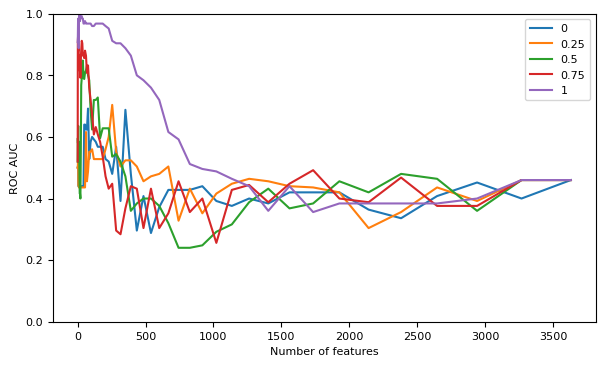

In [112]:
fig, ax = plt.subplots(1,1, figsize=(7, 4))
plt.plot(featRank_A["performance"].nFeats, featRank_A["performance"].auc) 
plt.plot(featRank_C["performance"].nFeats, featRank_C["performance"].auc) 
plt.plot(featRank_D["performance"].nFeats, featRank_D["performance"].auc) 
plt.plot(featRank_E["performance"].nFeats, featRank_E["performance"].auc)
plt.plot(featRank_B["performance"].nFeats, featRank_B["performance"].auc) 

plt.ylim(0,1)

plt.legend(['0','0.25','0.5','0.75','1'])
plt.ylabel('ROC AUC')
plt.xlabel('Number of features')
plt.show()

In [113]:
#saving figure
# figDirectory = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/"
# figFolder = "SVM_Mistic_Draft_Output_2024-07-11_v1"
figCommon = fileName_common + "fig1"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
fig.savefig(figPath, bbox_inches = 'tight')

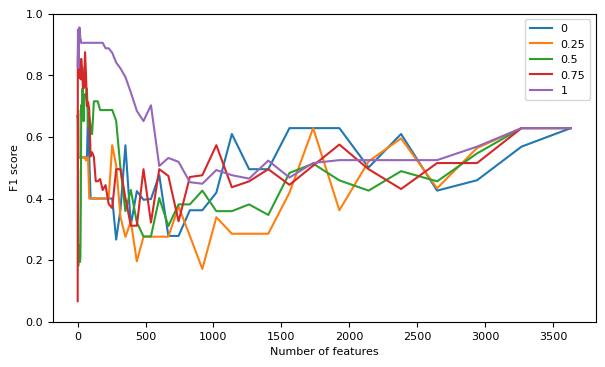

In [114]:
fig, ax = plt.subplots(1,1, figsize=(7, 4))
plt.plot(featRank_A["performance"].nFeats, featRank_A["performance"].f1) 
plt.plot(featRank_C["performance"].nFeats, featRank_C["performance"].f1) 
plt.plot(featRank_D["performance"].nFeats, featRank_D["performance"].f1) 
plt.plot(featRank_E["performance"].nFeats, featRank_E["performance"].f1) 
plt.plot(featRank_B["performance"].nFeats, featRank_B["performance"].f1) 

plt.ylim(0,1)

plt.legend(['0','0.25','0.5','0.75','1'])
plt.ylabel('F1 score')
plt.xlabel('Number of features')
plt.show()


In [115]:
figCommon = fileName_common + "fig2"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

### narrower window performance plots

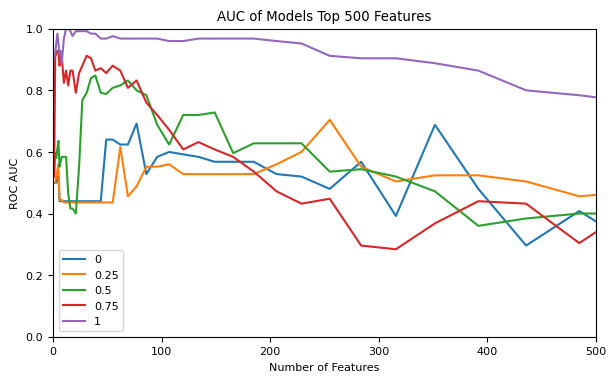

In [116]:
fig, ax = plt.subplots(1,1, figsize=(7, 4))
plt.plot(featRank_A["performance"].nFeats, featRank_A["performance"].auc) 
plt.plot(featRank_C["performance"].nFeats, featRank_C["performance"].auc) 
plt.plot(featRank_D["performance"].nFeats, featRank_D["performance"].auc) 
plt.plot(featRank_E["performance"].nFeats, featRank_E["performance"].auc)
plt.plot(featRank_B["performance"].nFeats, featRank_B["performance"].auc) 

plt.ylim(0,1)
plt.xlim(0,500)

plt.legend(['0','0.25','0.5','0.75','1'])
plt.ylabel('ROC AUC')
plt.xlabel('Number of Features')
plt.title("AUC of Models Top 500 Features")
plt.show()

In [117]:
figCommon = fileName_common + "fig1_top500"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
fig.savefig(figPath, bbox_inches = 'tight')

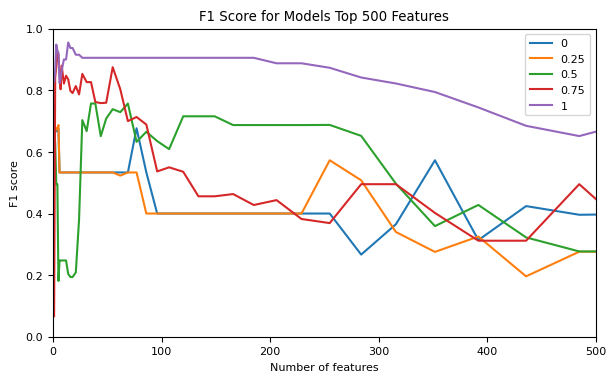

In [118]:
fig, ax = plt.subplots(1,1, figsize=(7, 4))
plt.plot(featRank_A["performance"].nFeats, featRank_A["performance"].f1) 
plt.plot(featRank_C["performance"].nFeats, featRank_C["performance"].f1) 
plt.plot(featRank_D["performance"].nFeats, featRank_D["performance"].f1) 
plt.plot(featRank_E["performance"].nFeats, featRank_E["performance"].f1) 
plt.plot(featRank_B["performance"].nFeats, featRank_B["performance"].f1) 

plt.ylim(0,1)
plt.xlim(0,500)

plt.legend(['0','0.25','0.5','0.75','1'])
plt.ylabel('F1 score')
plt.xlabel('Number of features')
plt.title("F1 Score for Models Top 500 Features")
plt.show()


In [119]:
figCommon = fileName_common + "fig2_top500"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

### Input the top 3 features from your data set into the following plot for a 3D visualization

In [120]:
X.columns[featRank_D["sorted"].astype(int)]

Index(['B12 Result (pg/mL) Quadratic Force coef A',
       'NT Pro BNP (B-Type Natriuretic Peptide) Linear NotForced RegresDesc 50%',
       'Nucleated RBC Result Linear NotForced RegresDesc 50%',
       'Nucleated RBC Result Linear Forced RegresDesc std',
       'Ferritin Result(ng/mL) Linear NotForced RegresDesc std',
       'Platelet Count Result(k/uL) Linear Forced residual error',
       'Ferritin Result(ng/mL) Linear NotForced RegresDesc 75%',
       'Ferritin Result(ng/mL) Exp2 Force RegresDesc 50%',
       'Ferritin Result(ng/mL) Linear NotForced RegresDesc max',
       'Ferritin Result(ng/mL) Linear NotForced RegresDesc min',
       ...
       'Glucose Result Desc mean', 'Ferritin Result(ng/mL) Desc max',
       'Erythrocyte SR Result Desc 75%', 'Erythrocyte SR Result Desc 50%',
       'Erythrocyte SR Result Desc 25%', 'Erythrocyte SR Result Desc mean',
       'Creatinine Result(mg/dL) Desc min', 'Calcium Result(mg/dL) Desc 75%',
       'BUN Result(mg/dL) Desc mean', 'Dx'],
  

In [121]:
listX = list(X.columns[featRank_D["sorted"].astype(int)])

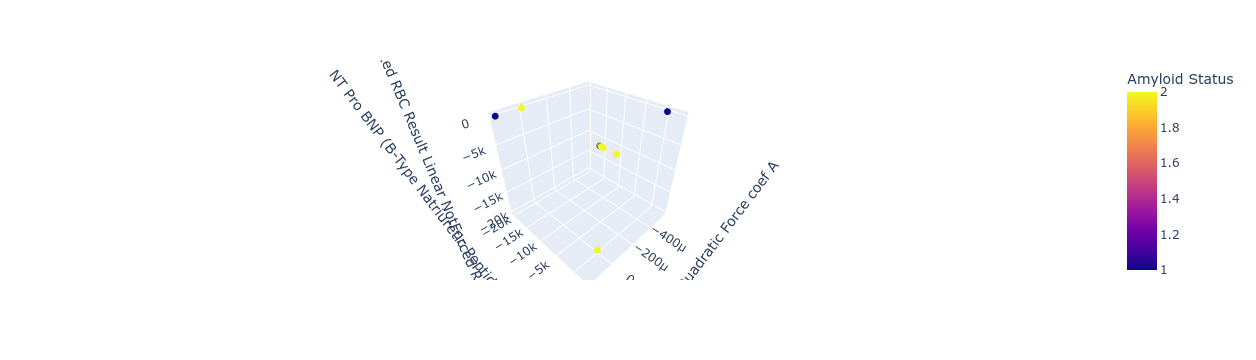

In [122]:
fig = px.scatter_3d(dataTable, x=listX[0], y=listX[1], z=listX[2],
              color= y_column_Classification)
fig.update_traces(marker_size = 4)
fig.show()

### performance outputs
set the number of features you want to check the performance with

In [123]:
#setting number of features for performance test
fold = 0
number_feat_perf_test = 25 #describes for testing performance 
numb_features_figures = 5 #number of features to use in plots

In [124]:
# queryText = "nFeats == " + str(number_feat_perf_test)
# featRank_B["performance"].query(queryText)

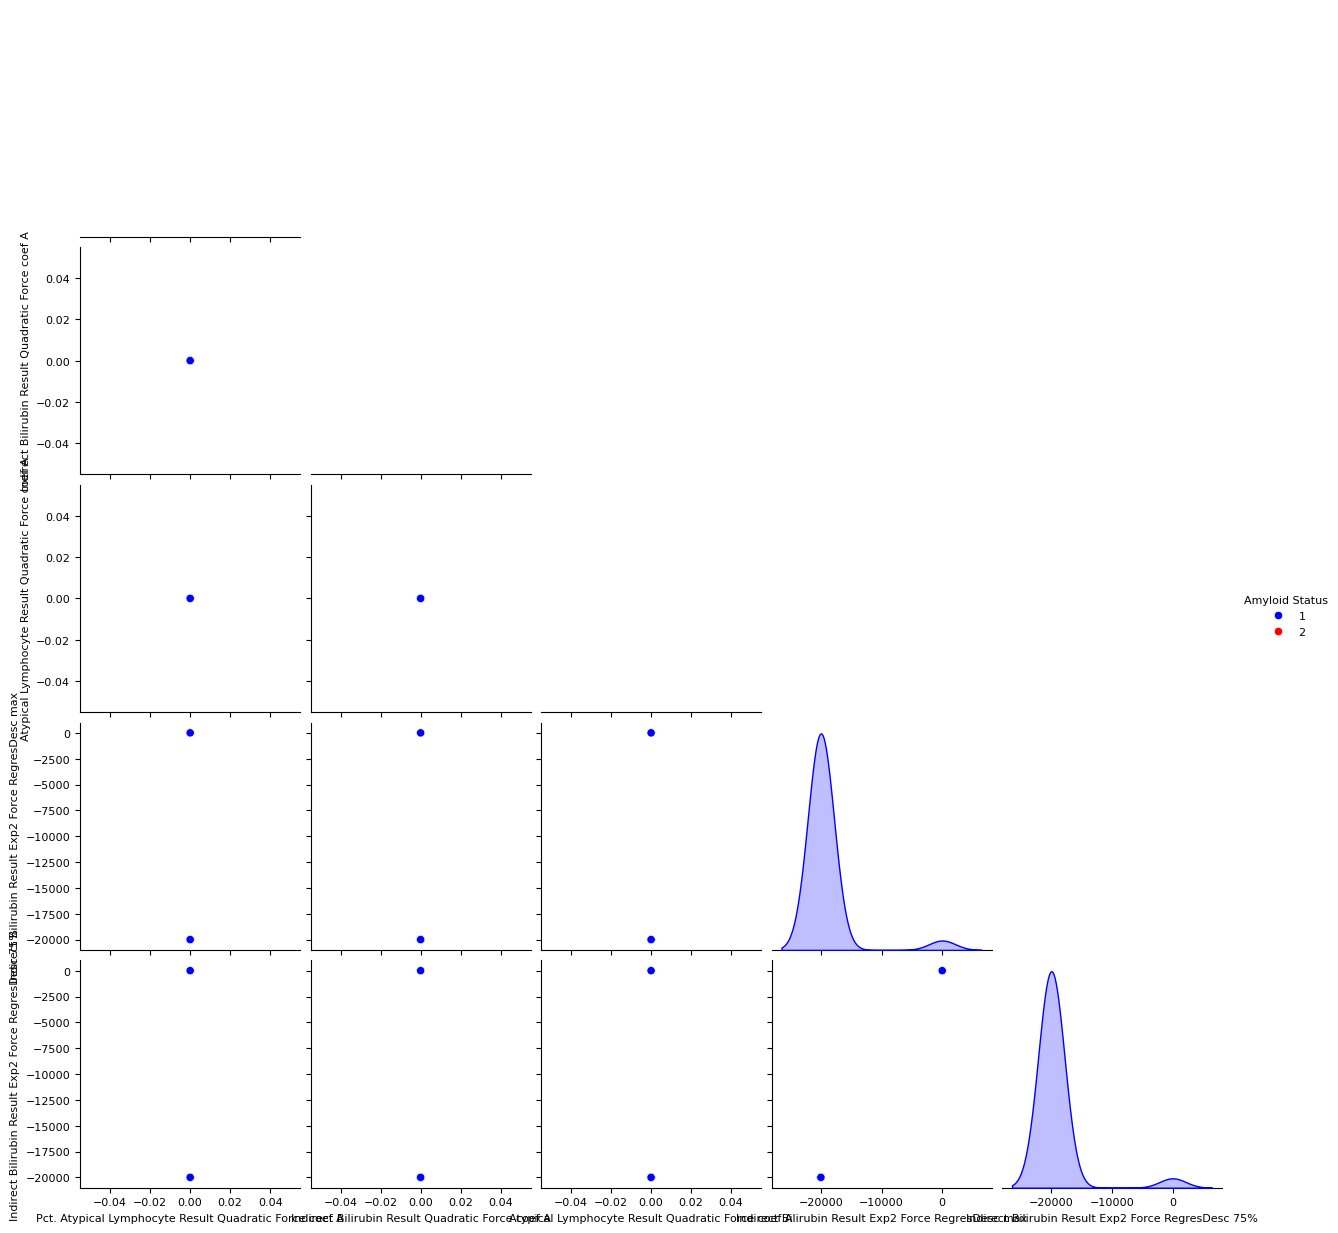

In [125]:
palette = {np.int64(2) :'red', np.int64(1): 'blue'} #our data is of int64
featuresToPlot = list(X.columns[featRank_A["sorted"].astype(int)][0:numb_features_figures])
featuresToPlot.extend([y_column_Classification]) #must include the final classification column 

fig = pairplot(dataTable[featuresToPlot],hue= y_column_Classification, corner=True, palette=palette)
# fig.title("featRank_A compare features")

figCommon = fileName_common + "featRankA"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

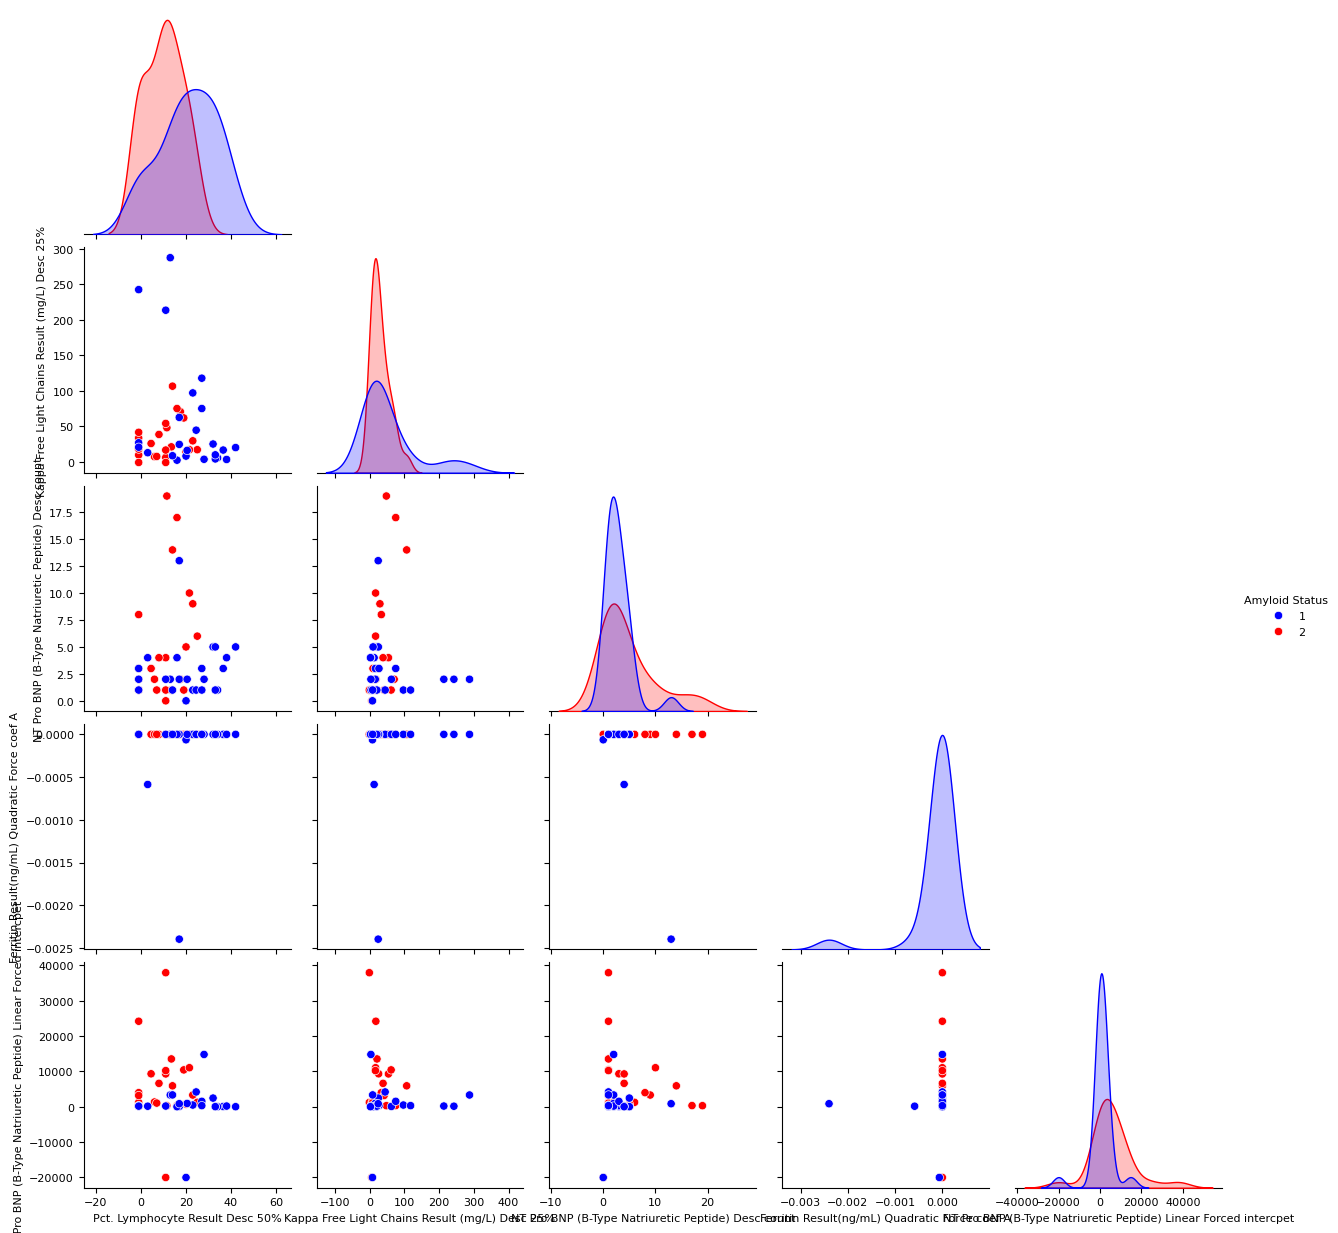

In [126]:
palette = {np.int64(2) :'red', np.int64(1): 'blue'} #our data is of int64
featuresToPlot = list(X.columns[featRank_B["sorted"].astype(int)][0:numb_features_figures])
featuresToPlot.extend([y_column_Classification]) #must include the final classification column 

fig = pairplot(dataTable[featuresToPlot],hue= y_column_Classification, corner=True, palette=palette)
# fig.title("featRank_A 5 features", loc = 'center')

figCommon = fileName_common + "featRankB_5"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

In [127]:
# queryText = "nFeats == " + str(number_feat_perf_test)
# featRank_E["performance"].query(queryText)

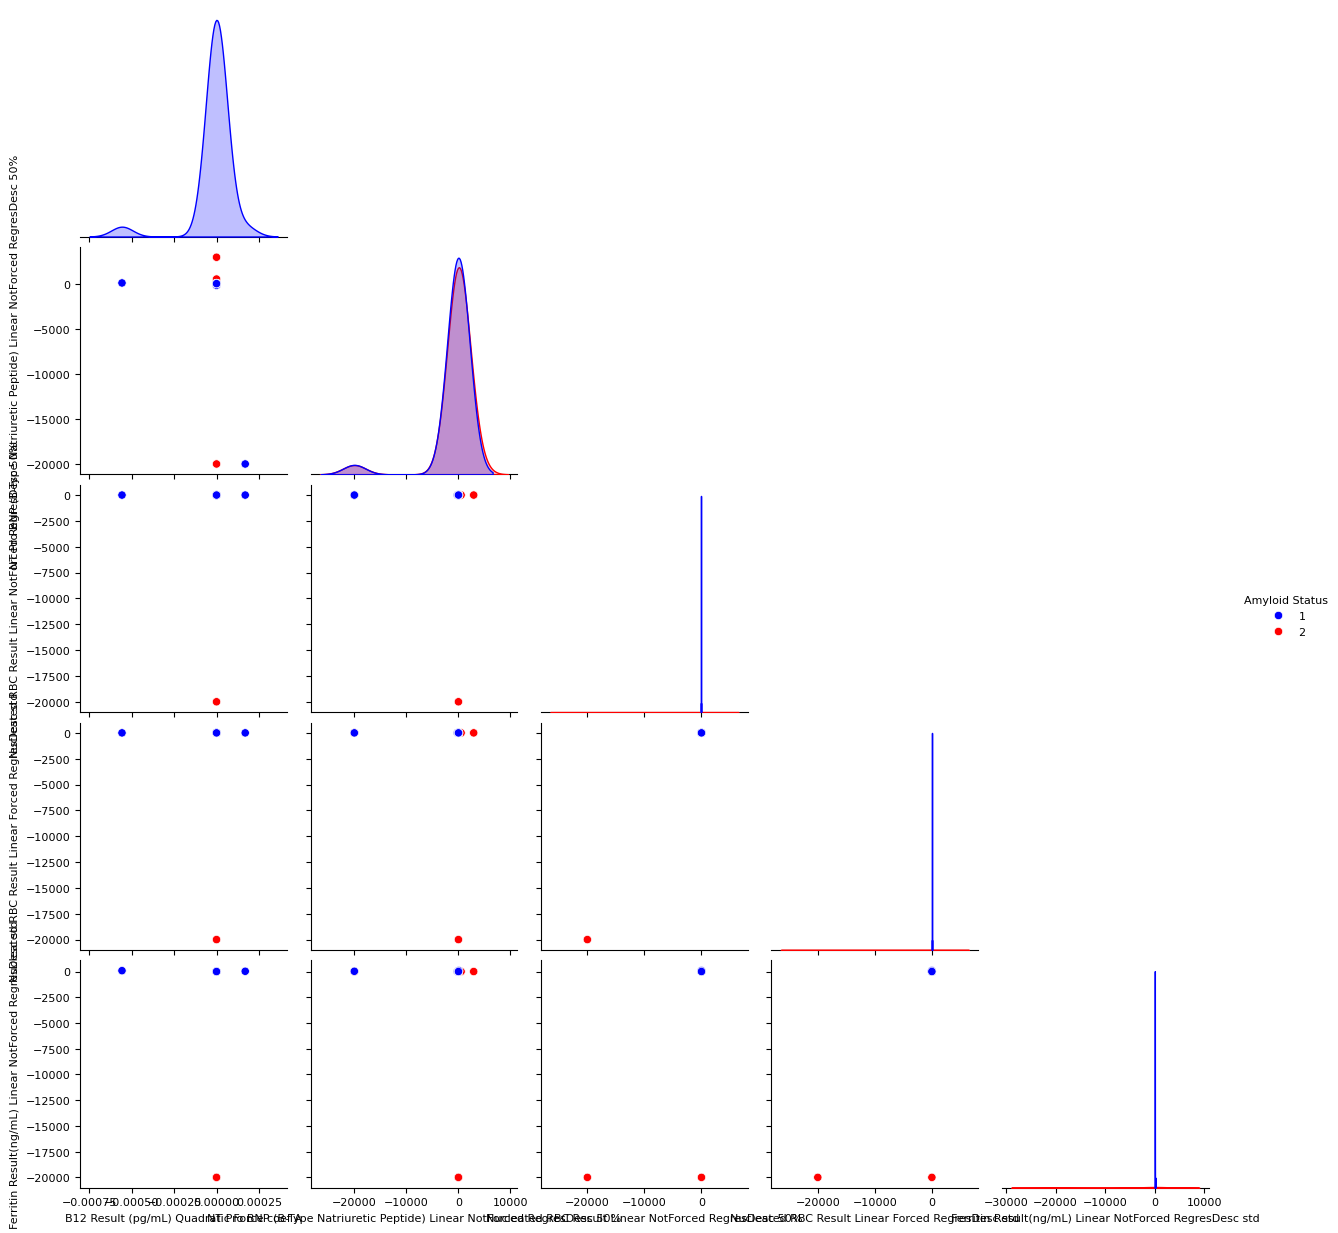

In [128]:
palette = {np.int64(2) :'red', np.int64(1): 'blue'} #our data is of int64
featuresToPlot = list(X.columns[featRank_D["sorted"].astype(int)][0:numb_features_figures])
featuresToPlot.extend([y_column_Classification]) #must include the final classification column 

fig = pairplot(dataTable[featuresToPlot],hue= y_column_Classification, corner=True, palette=palette)
# fig.title("featRank_A 5 features", loc = 'center')

figCommon = fileName_common + "featRankD_5"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

In [129]:
# pairplot(dataTable[['Area worst', 'Concave Points worst', 'Texture worst','Diagnosis']],hue="Diagnosis", corner=True, palette={"M":"red","B":"blue"})

In [130]:
# tesTune2 = tuneSVM(svc, CV_sets, score_method = svc_score().score, costs = C_range, gammas = gamma_range,feature_index=featRank_D["sorted"][0:10].astype(int))
# tesTune2["best_params"]

# to use best features from a feature selection process

In [131]:
modelD_Features = featRank_D["best_features"] #to get the best features which take highest score and highest C
modelD_FeaturesInt = featRank_D["best_features"].astype(int) #convert these to ints? to use as column finding for x.columns?
modelD_numbFeatures = len(modelD_FeaturesInt) #number of features

#list of column names
modelD_FeaturesIntList = X.columns[featRank_D["best_features"].astype(int)]

In [132]:
modelE_Features = featRank_E["best_features"] #to get the best features which take highest score and highest C
modelE_FeaturesInt = featRank_E["best_features"].astype(int) #convert these to ints? to use as column finding for x.columns?
modelE_numbFeatures = len(modelE_FeaturesInt) #number of features

#list of column names
modelE_FeaturesIntList = X.columns[featRank_E["best_features"].astype(int)]

In [133]:
modelB_Features = featRank_B["best_features"] #to get the best features which take highest score and highest C
modelB_FeaturesInt = featRank_B["best_features"].astype(int) #convert these to ints? to use as column finding for x.columns?
modelB_numbFeatures = len(modelB_FeaturesInt) #number of features

#list of column names
modelB_FeaturesIntList = X.columns[featRank_B["best_features"].astype(int)]

## Figures for weighting 0.5

In [134]:
#creation of tesTune_05
tesTune05 = tuneSVM(svc, CV_sets, score_method = svc_score().score, costs = C_range, gammas = gamma_range,feature_index=modelD_FeaturesInt)
print(tesTune05["best_params"])

   c  g        f1    auc    score
0  2  1  0.757179  0.848  0.80259


In [135]:
#pickling of tesTune_05
pickle_file_name = 'tesTune05_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(tesTune05, pickle_file)

In [136]:
#setting the parameters for the plots below
featuresInt = modelD_FeaturesInt
numbFeatures = modelD_numbFeatures
ListFeatureColNames = modelD_FeaturesIntList

#setting the tuned SVM model for the plots below
tunedModel = tesTune05

In [137]:
# feat_contribution = compute_SV_decision_perturbation(tunedModel["best_models"][fold],CV_sets[fold]["test"]["X"][:,featuresInt])
# FItable = pd.DataFrame(feat_contribution, index=CV_sets[fold]["test"]["y"],columns=ListFeatureColNames)

# FItable.reset_index(drop=True, inplace=True)
# fig = clustermap(FItable.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:], 
#            yticklabels=False,
#            cmap="vlag", vmin=-0.4, vmax=0.4,
#            #row_linkage=hcRow, col_linkage=hcCol, 
#            row_cluster=False,col_cluster=False,
#            cbar_pos=(1, .2, .03, .4),
#            row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets[0]["test"]["y"].values[np.argsort(CV_sets[fold]["test"]["y"].values)]])
# plt.suptitle("Test Patients Contribution when training with "+  str(numbFeatures)+ " best features I-C weight 0.5")

# figCommon = fileName_common + "fig3_w05"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

In [138]:
CV_sets_trainANDtest_X = np.concatenate((CV_sets[fold]["train"]["X"][:,featuresInt],CV_sets[fold]["test"]["X"][:,featuresInt]), axis =0)
CV_sets_trainANDtest_y = np.concatenate((CV_sets[fold]["train"]["y"],CV_sets[fold]["test"]["y"]), axis = 0)



In [139]:
# feat_contribution = compute_SV_decision_perturbation(tunedModel["best_models"][fold],CV_sets_trainANDtest_X)
# FItable = pd.DataFrame(feat_contribution, index=CV_sets_trainANDtest_y,columns=ListFeatureColNames)

# FItable.reset_index(drop=True, inplace=True)
# fig = clustermap(FItable.iloc[np.argsort(CV_sets_trainANDtest_y),:], 
#            yticklabels=False,
#            cmap="vlag", vmin=-0.4, vmax=0.4,
#            #row_linkage=hcRow, col_linkage=hcCol, 
#            row_cluster=False,col_cluster=False,
#            cbar_pos=(1, .2, .03, .4),
#            row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y[np.argsort(CV_sets_trainANDtest_y)]])
# plt.suptitle("Contribution test-train when training with best "+  str(numbFeatures)+ " features I-C weight 0.5")

# figCommon = fileName_common + "fig3_2_w05"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

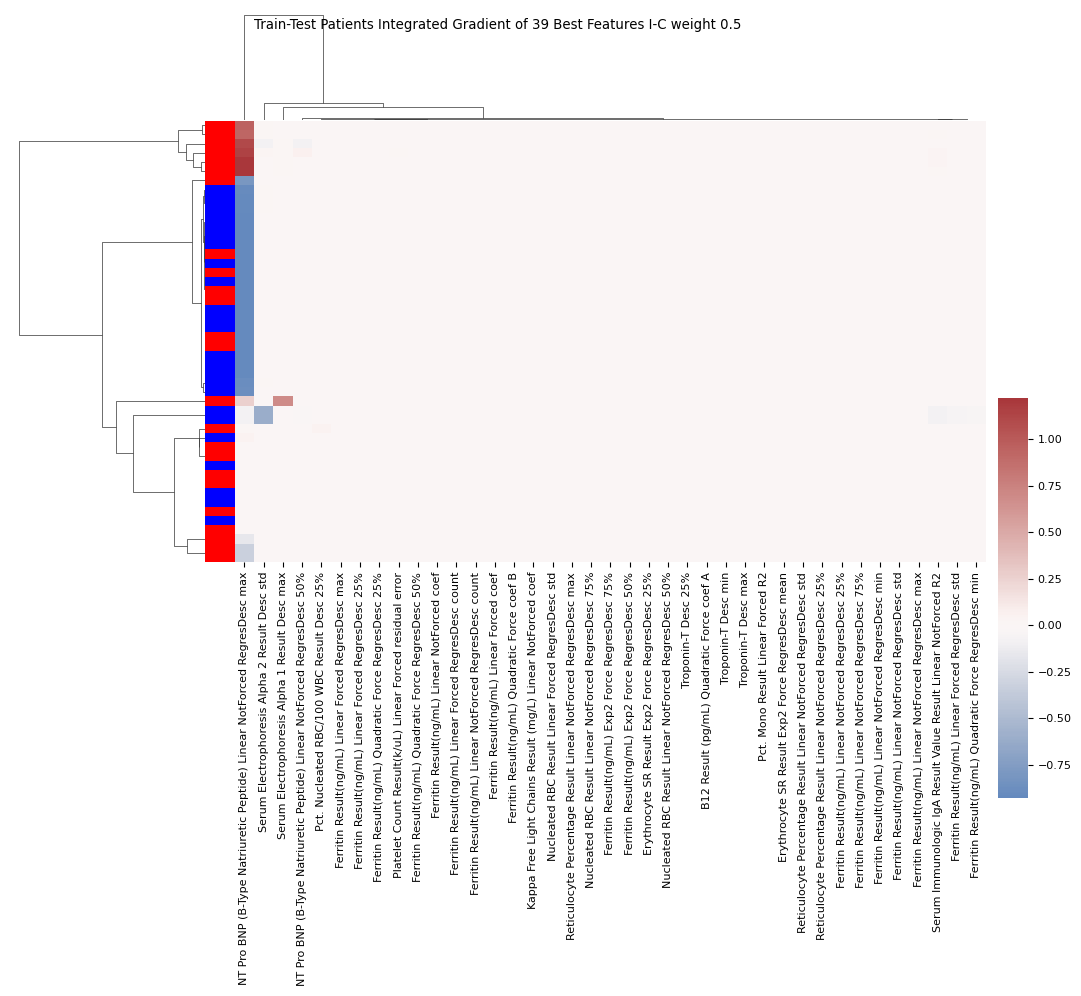

In [140]:
# CV_sets_trainANDtest_X = np.concatenate((CV_sets[fold]["train"]["X"][:,modelD_FeaturesInt],CV_sets[fold]["test"]["X"][:,modelD_FeaturesInt]), axis =0)
# CV_sets_trainANDtest_y = np.concatenate((CV_sets[fold]["train"]["y"],CV_sets[fold]["test"]["y"]), axis = 0)

IG = compute_SV_integrated_gradient(tunedModel["best_models"][fold], CV_sets_trainANDtest_X)

IGtable = pd.DataFrame(IG,columns=X.columns[modelD_FeaturesInt])

fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=IGtable.min().min(), vmax=IGtable.max().max(), center = 0,
           #row_linkage=hcRow, col_linkage=hcCol, 
           cbar_pos=(1, .2, .03, .4),
        #    row_colors=[["red","blue"][int(l=="B")+0] for l in CV_sets[0]["test"]["y"].values]
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y])
plt.suptitle("Train-Test Patients Integrated Gradient of "+  str(numbFeatures)+ " Best Features I-C weight 0.5")
plt.show()

figCommon = fileName_common + "fig4_w05"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

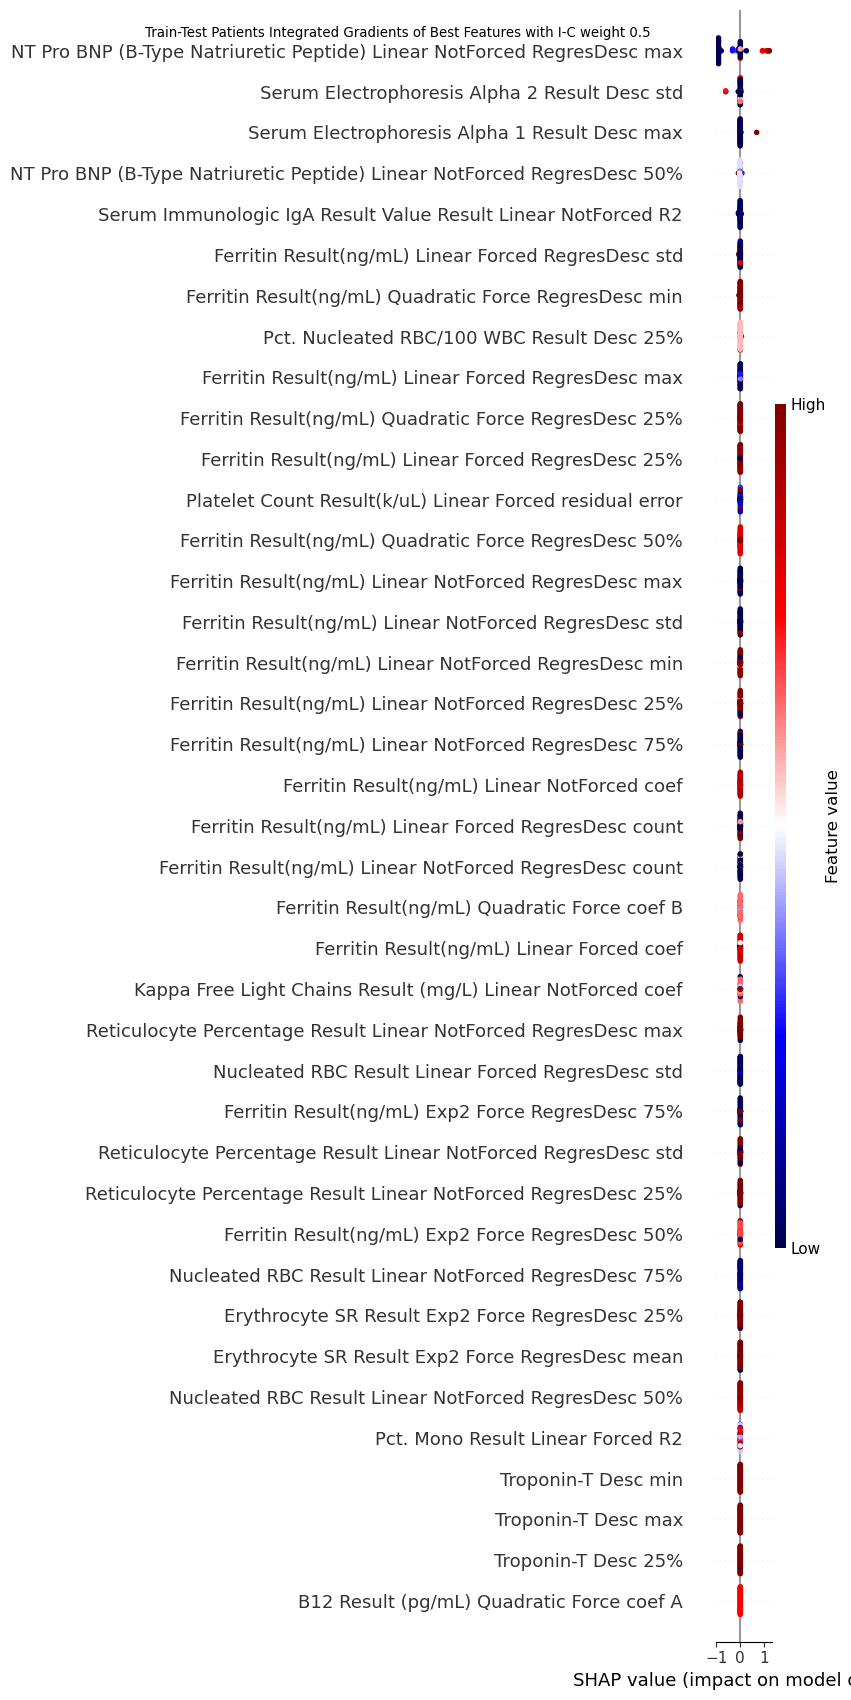

In [141]:
# number_feat_perf_test = 25
fig = shap.summary_plot(IG,  CV_sets_trainANDtest_X, max_display=numbFeatures , 
                  feature_names=ListFeatureColNames,cmap="seismic", show = False)
plt.suptitle("Train-Test Patients Integrated Gradients of Best Features with I-C weight 0.5")
figCommon = fileName_common + "fig5_w05"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')

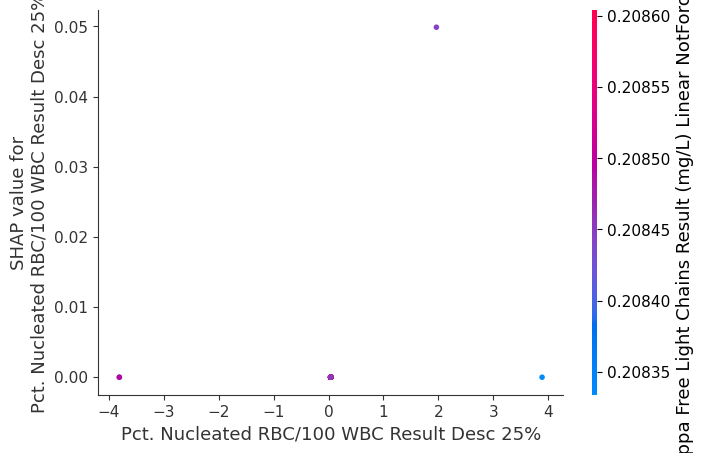

In [142]:
Xcv = pd.DataFrame(CV_sets_trainANDtest_X, 
                     index=CV_sets_trainANDtest_y,
                     columns=X.columns[modelD_FeaturesInt])

fig6_feature_to_plot= ListFeatureColNames[0]

shap.dependence_plot( fig6_feature_to_plot , IG, Xcv, show = False)

figCommon = fileName_common + "fig6_w05"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')

In [143]:
# np.argsort(CV_sets[fold]["test"]["y"].values)

In [144]:
# topFeaturesNumber = number_feat_perf_test

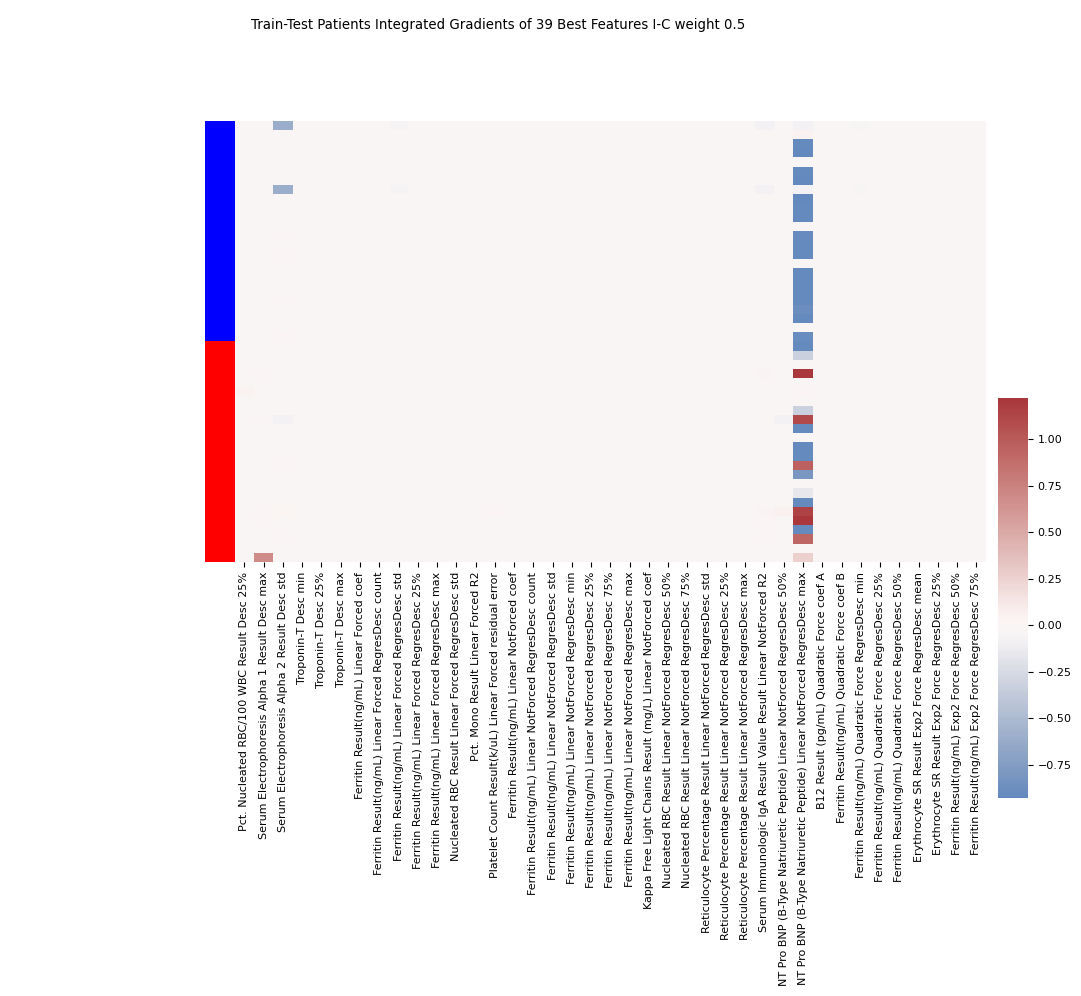

In [145]:
# Xtop3 = pd.DataFrame(CV_sets[fold]["test"]["X"][:,featRank_D["sorted"][0:topFeaturesNumber ].astype(int)], 
#                      index=CV_sets[fold]["test"]["y"],
#                      columns=X.columns[modelD_FeaturesInt])
# IG = compute_SV_integrated_gradient(tesTune05["best_models"][fold],
#                                    CV_sets[fold]["test"]["X"][:,modelD_FeaturesInt])

IGtable_wIndex = pd.DataFrame(IG, index=CV_sets_trainANDtest_y, columns=ListFeatureColNames)

IGtable_wIndex.reset_index(drop=True, inplace=True)
fig = clustermap(IGtable_wIndex.iloc[np.argsort(CV_sets_trainANDtest_y),:], 
           yticklabels=False,
           col_cluster=False,
           row_cluster=False,
           cmap="vlag", vmin=IGtable_wIndex.min().min(), vmax=IGtable_wIndex.max().max(), center = 0, 
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y[np.argsort(CV_sets_trainANDtest_y)]])

plt.suptitle("Train-Test Patients Integrated Gradients of "+ str(numbFeatures) +' Best Features I-C weight 0.5')
plt.show()

figCommon = fileName_common + "fig7_w05"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

In [146]:
# CV_sets_trainANDtest_X = np.concatenate((CV_sets[fold]["train"]["X"][:,modelD_FeaturesInt],CV_sets[fold]["test"]["X"][:,modelD_FeaturesInt]), axis =0)
# CV_sets_trainANDtest_y = np.concatenate((CV_sets[fold]["train"]["y"],CV_sets[fold]["test"]["y"]), axis = 0)

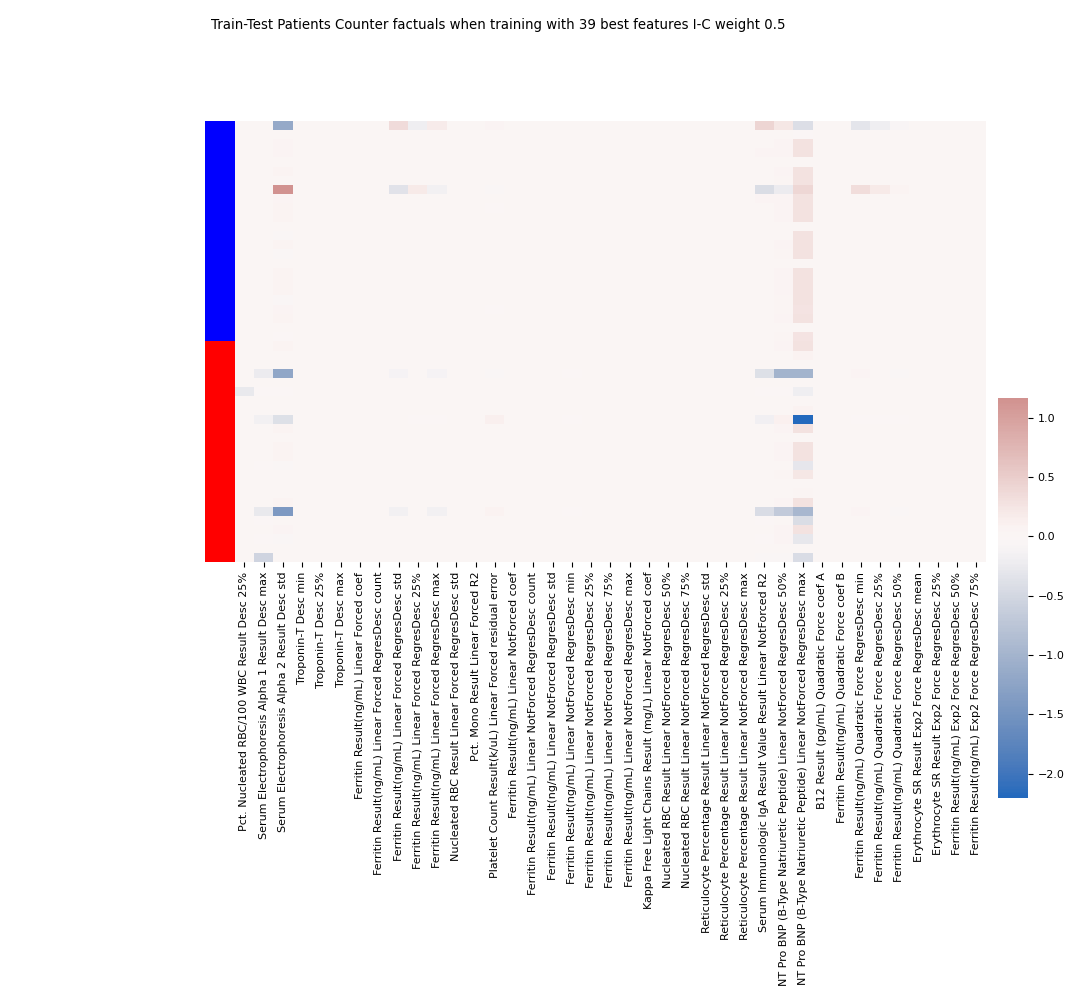

In [147]:
counterfactuals = compute_counterfactuals(tunedModel["best_models"][fold], 
                                          CV_sets_trainANDtest_X)
CFtable = pd.DataFrame(counterfactuals, 
                       index=CV_sets_trainANDtest_y,columns=X.columns[modelD_FeaturesInt])

CFtable.reset_index(drop=True, inplace=True)
fig = clustermap(CFtable.iloc[np.argsort(CV_sets_trainANDtest_y),:],#/abs(Xtop3.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:]), 
           yticklabels=False,
           col_cluster=False,
           row_cluster=False,
           cmap="vlag", vmin=CFtable.min().min(), vmax=CFtable.max().max(), center =0,
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y[np.argsort(CV_sets_trainANDtest_y)]])
plt.suptitle("Train-Test Patients Counter factuals when training with "+ str(numbFeatures) +' best features I-C weight 0.5')
# plt.show()

figCommon = fileName_common + "fig9_w05"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

In [148]:
# #pickling the tesTune object
# pickle_file = open('tesTune2_object_file', 'wb')
# pickle.dump(tesTune2, pickle_file)

In [149]:
# pickle_file_name = 'tesTune05_object_' + fileName_header +fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'wb')
# pickle.dump(tesTune05, pickle_file)

## hyper parameter tuning for best features 0.75 weighting

In [150]:
modelE_Features = featRank_E["best_features"] #to get the best features which take highest score and highest C
modelE_FeaturesInt = featRank_E["best_features"].astype(int) #convert these to ints? to use as column finding for x.columns?
modelE_numbFeatures = len(modelE_FeaturesInt) #number of features

#list of column names
modelE_FeaturesIntList = X.columns[featRank_E["best_features"].astype(int)]

In [151]:
#setting the parameters for the plots below
featuresInt = modelE_FeaturesInt
numbFeatures = modelE_numbFeatures
ListFeatureColNames = modelE_FeaturesIntList

In [152]:
#creation of classifier using the features found in ranking above
#creation of tesTune_075
tesTune075 = tuneSVM(svc, CV_sets, score_method = svc_score().score, costs = C_range, gammas = gamma_range,feature_index=featuresInt)
print(tesTune075["best_params"])

      c         g    f1    auc  score
0  0.25  0.007812  0.92  0.928  0.924


In [153]:
#pickling tesTune075
pickle_file_name = 'tesTune075_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(tesTune075, pickle_file)

In [154]:
#setting the tuned SVM model for the plots below
tunedModel = tesTune075

In [155]:
# #feature contribution plot using only the test data
# feat_contribution = compute_SV_decision_perturbation(tunedModel["best_models"][fold],CV_sets[fold]["test"]["X"][:,featuresInt])
# FItable = pd.DataFrame(feat_contribution, index=CV_sets[fold]["test"]["y"],columns=ListFeatureColNames)

# FItable.reset_index(drop=True, inplace=True)
# fig = clustermap(FItable.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:], 
#            yticklabels=False,
#            cmap="vlag", vmin=-0.4, vmax=0.4,
#            #row_linkage=hcRow, col_linkage=hcCol, 
#            row_cluster=False,col_cluster=False,
#            cbar_pos=(1, .2, .03, .4),
#            row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets[0]["test"]["y"].values[np.argsort(CV_sets[fold]["test"]["y"].values)]])
# plt.suptitle("Test Patients Contribution when training with "+  str(numbFeatures)+ " best features I-C weight 0.75")

# figCommon = fileName_common + "fig3_w075"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

In [156]:
#feature contribution cluster map for all test and train patients
CV_sets_trainANDtest_X = np.concatenate((CV_sets[fold]["train"]["X"][:,featuresInt],CV_sets[fold]["test"]["X"][:,featuresInt]), axis =0)
CV_sets_trainANDtest_y = np.concatenate((CV_sets[fold]["train"]["y"],CV_sets[fold]["test"]["y"]), axis = 0)



In [157]:
feat_contribution = compute_SV_decision_perturbation(tunedModel["best_models"][fold],CV_sets_trainANDtest_X)
# FItable = pd.DataFrame(feat_contribution, index=CV_sets_trainANDtest_y,columns=ListFeatureColNames)

# FItable.reset_index(drop=True, inplace=True)
# fig = clustermap(FItable.iloc[np.argsort(CV_sets_trainANDtest_y),:], 
#            yticklabels=False,
#            cmap="vlag", vmin=-0.4, vmax=0.4,
#            #row_linkage=hcRow, col_linkage=hcCol, 
#            row_cluster=False,col_cluster=False,
#            cbar_pos=(1, .2, .03, .4),
#            row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y[np.argsort(CV_sets_trainANDtest_y)]])
# plt.suptitle("Contribution test-train when training with best "+  str(numbFeatures)+ " features I-C weight 0.75")

# figCommon = fileName_common + "fig3_2_w075"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

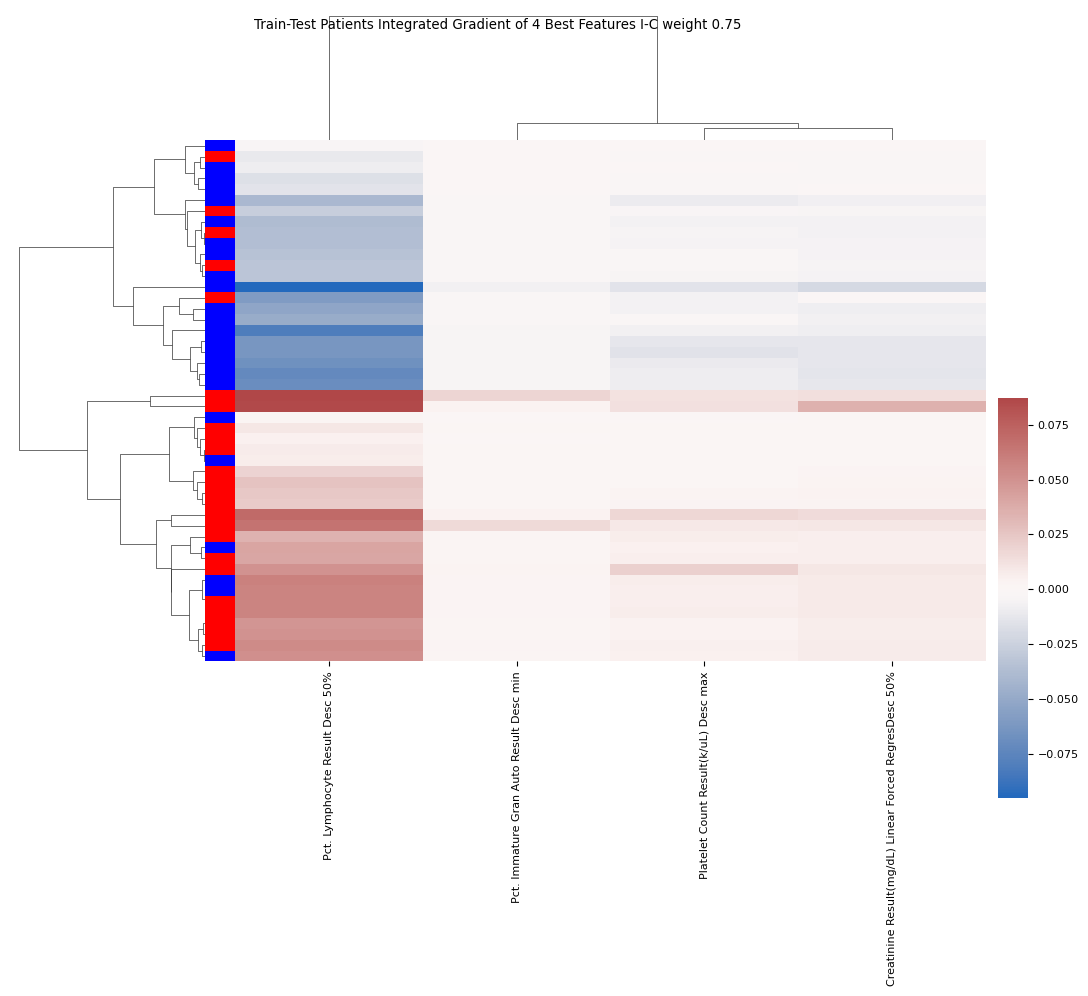

In [158]:
#integrated gradient cluster map with heigharchical clustering

IG = compute_SV_integrated_gradient(tunedModel["best_models"][fold], CV_sets_trainANDtest_X)

IGtable = pd.DataFrame(IG,columns=ListFeatureColNames)

fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=IGtable.min().min(), vmax=IGtable.max().max(), center = 0, 
           #row_linkage=hcRow, col_linkage=hcCol, 
           cbar_pos=(1, .2, .03, .4),
        #    row_colors=[["red","blue"][int(l=="B")+0] for l in CV_sets[0]["test"]["y"].values]
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y])
plt.suptitle("Train-Test Patients Integrated Gradient of "+  str(numbFeatures)+ " Best Features I-C weight 0.75")
plt.show()

figCommon = fileName_common + "fig4_w075"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

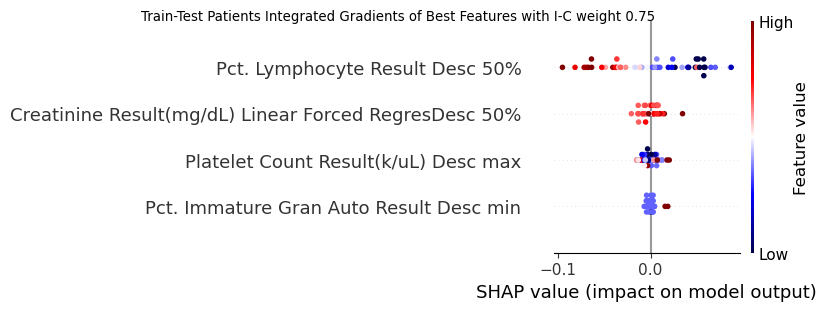

In [159]:
#shap plot for integrated gradients
fig = shap.summary_plot(IG,  CV_sets_trainANDtest_X, max_display=numbFeatures , 
                  feature_names=ListFeatureColNames,cmap="seismic", show = False)
plt.suptitle("Train-Test Patients Integrated Gradients of Best Features with I-C weight 0.75")
figCommon = fileName_common + "fig5_w075"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')

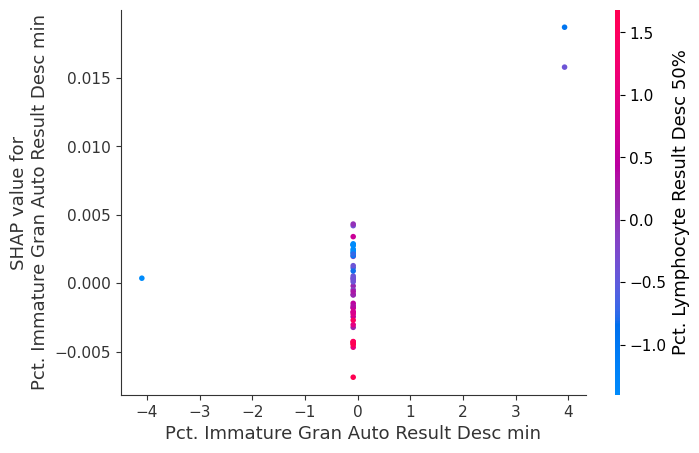

In [160]:
#shap dependence plot
Xcv = pd.DataFrame(CV_sets_trainANDtest_X, 
                     index=CV_sets_trainANDtest_y,
                     columns=ListFeatureColNames)

fig6_feature_to_plot= ListFeatureColNames[0]

shap.dependence_plot( fig6_feature_to_plot , IG, Xcv, show = False)

figCommon = fileName_common + "fig6_w075"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')

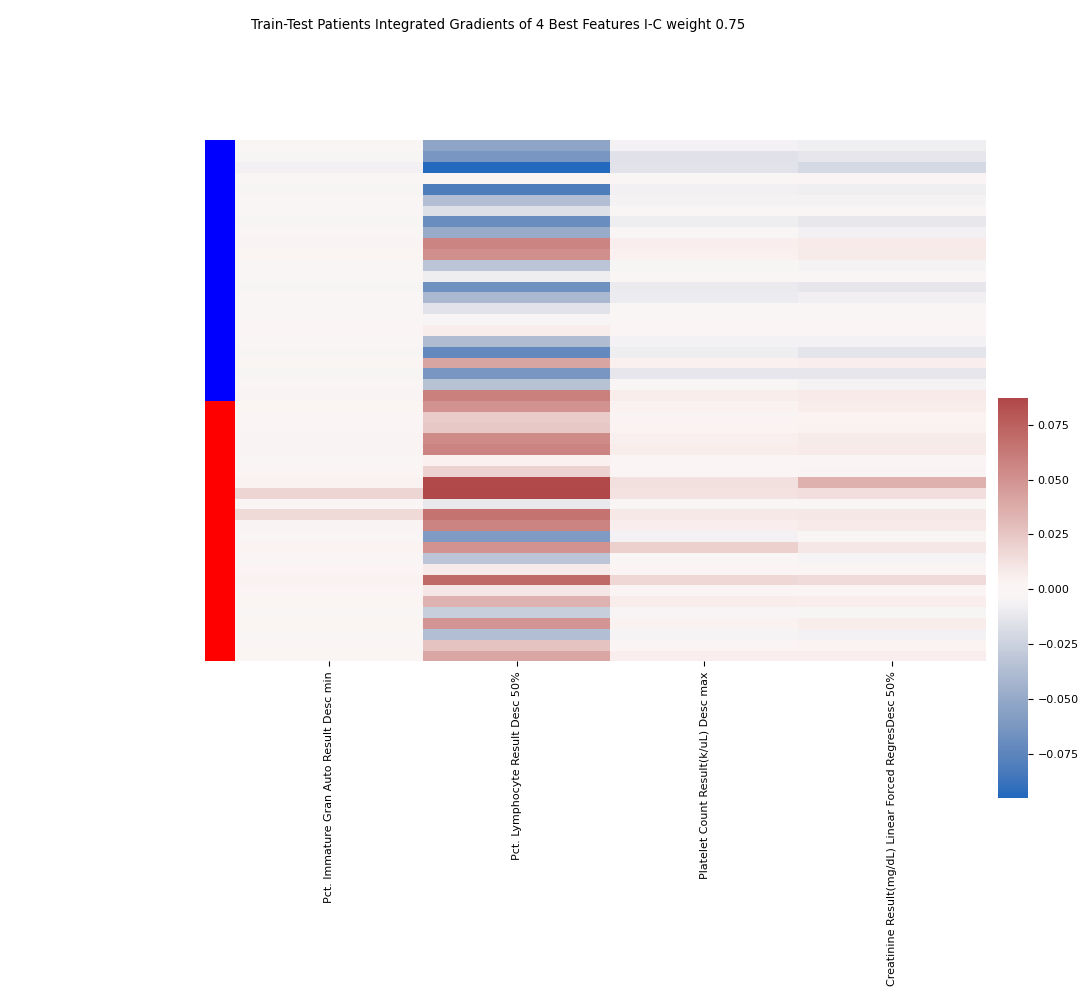

In [161]:
#cluster map of integrated gradients sorted by index
IGtable_wIndex = pd.DataFrame(IG, index=CV_sets_trainANDtest_y, columns=ListFeatureColNames)

IGtable_wIndex.reset_index(drop=True, inplace=True)
fig = clustermap(IGtable_wIndex.iloc[np.argsort(CV_sets_trainANDtest_y),:], 
           yticklabels=False,
           col_cluster=False,
           row_cluster=False,
           cmap="vlag", vmin=IGtable_wIndex.min().min(), vmax=IGtable_wIndex.max().max(), center = 0, 
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y[np.argsort(CV_sets_trainANDtest_y)]])

plt.suptitle("Train-Test Patients Integrated Gradients of "+ str(modelE_numbFeatures) +' Best Features I-C weight 0.75')
plt.show()

figCommon = fileName_common + "fig7_w075"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

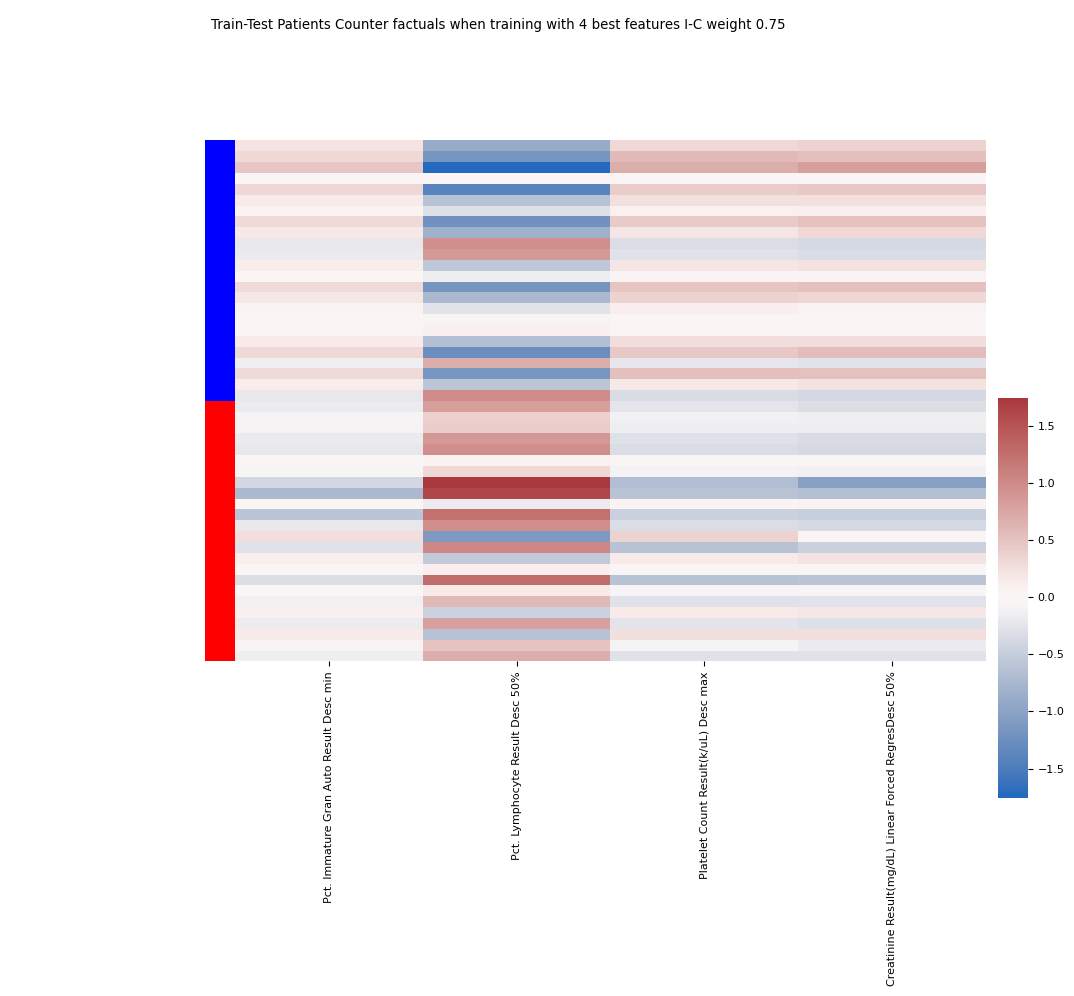

In [162]:
#counter factuals map
counterfactuals = compute_counterfactuals(tunedModel["best_models"][fold], 
                                          CV_sets_trainANDtest_X)
CFtable = pd.DataFrame(counterfactuals, 
                       index=CV_sets_trainANDtest_y,columns=ListFeatureColNames)

CFtable.reset_index(drop=True, inplace=True)
fig = clustermap(CFtable.iloc[np.argsort(CV_sets_trainANDtest_y),:],#/abs(Xtop3.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:]), 
           yticklabels=False,
           col_cluster=False,
           row_cluster=False,
           cmap="vlag", vmin=CFtable.min().min(), vmax=CFtable.max().max(), center =0, 
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y[np.argsort(CV_sets_trainANDtest_y)]])
plt.suptitle("Train-Test Patients Counter factuals when training with "+ str(numbFeatures) +' best features I-C weight 0.75')
# plt.show()

figCommon = fileName_common + "fig9_w075"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

## hyperparameter tuning using list of best features from feature selection with only contribution featRank_B

In [163]:
modelB_Features = featRank_B["best_features"] #to get the best features which take highest score and highest C
modelB_FeaturesInt = featRank_B["best_features"].astype(int) #convert these to ints? to use as column finding for x.columns?
modelB_numbFeatures = len(modelB_FeaturesInt) #number of features

#list of column names
modelB_FeaturesIntList = X.columns[featRank_B["best_features"].astype(int)]

In [164]:
#setting the parameters for the plots below
featuresInt = modelB_FeaturesInt
numbFeatures = modelB_numbFeatures
ListFeatureColNames = modelB_FeaturesIntList

In [165]:
#creation of classifier using the features found in ranking above
#creation of tesTune_1
tesTune100 = tuneSVM(svc, CV_sets, score_method = svc_score().score, costs = C_range, gammas = gamma_range,feature_index=featuresInt)
print(tesTune100["best_params"])

   c      g        f1  auc     score
0  1  0.125  0.955556  1.0  0.977778


In [166]:
#pickling tesTune100
pickle_file_name = 'tesTune100_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(tesTune100, pickle_file)

In [167]:
#setting the tuned SVM model for the plots below
tunedModel = tesTune100

In [168]:
# #feature contribution plot using only the test data
# feat_contribution = compute_SV_decision_perturbation(tunedModel["best_models"][fold],CV_sets[fold]["test"]["X"][:,featuresInt])
# FItable = pd.DataFrame(feat_contribution, index=CV_sets[fold]["test"]["y"],columns=ListFeatureColNames)

# FItable.reset_index(drop=True, inplace=True)
# fig = clustermap(FItable.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:], 
#            yticklabels=False,
#            cmap="vlag", vmin=-1, vmax=1,
#            #row_linkage=hcRow, col_linkage=hcCol, 
#            row_cluster=False,col_cluster=False,
#            cbar_pos=(1, .2, .03, .4),
#            row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets[0]["test"]["y"].values[np.argsort(CV_sets[fold]["test"]["y"].values)]])
# plt.suptitle("Test Patients Contribution when training with "+  str(numbFeatures)+ " best features contribution only")

# figCommon = fileName_common + "fig3_w100"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

In [169]:
#feature contribution cluster map for all test and train patients
CV_sets_trainANDtest_X = np.concatenate((CV_sets[fold]["train"]["X"][:,featuresInt],CV_sets[fold]["test"]["X"][:,featuresInt]), axis =0)
CV_sets_trainANDtest_y = np.concatenate((CV_sets[fold]["train"]["y"],CV_sets[fold]["test"]["y"]), axis = 0)



In [170]:
# feat_contribution = compute_SV_decision_perturbation(tunedModel["best_models"][fold],CV_sets_trainANDtest_X)
# FItable = pd.DataFrame(feat_contribution, index=CV_sets_trainANDtest_y,columns=ListFeatureColNames)

# FItable.reset_index(drop=True, inplace=True)
# fig = clustermap(FItable.iloc[np.argsort(CV_sets_trainANDtest_y),:], 
#            yticklabels=False,
#            cmap="vlag", vmin=-1.2, vmax=1.2,
#            #row_linkage=hcRow, col_linkage=hcCol, 
#            row_cluster=False,col_cluster=False,
#            cbar_pos=(1, .2, .03, .4),
#            row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y[np.argsort(CV_sets_trainANDtest_y)]])
# plt.suptitle("Contribution test-train when training with best "+  str(numbFeatures)+ " features contribution only")

# figCommon = fileName_common + "fig3_2_w100"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

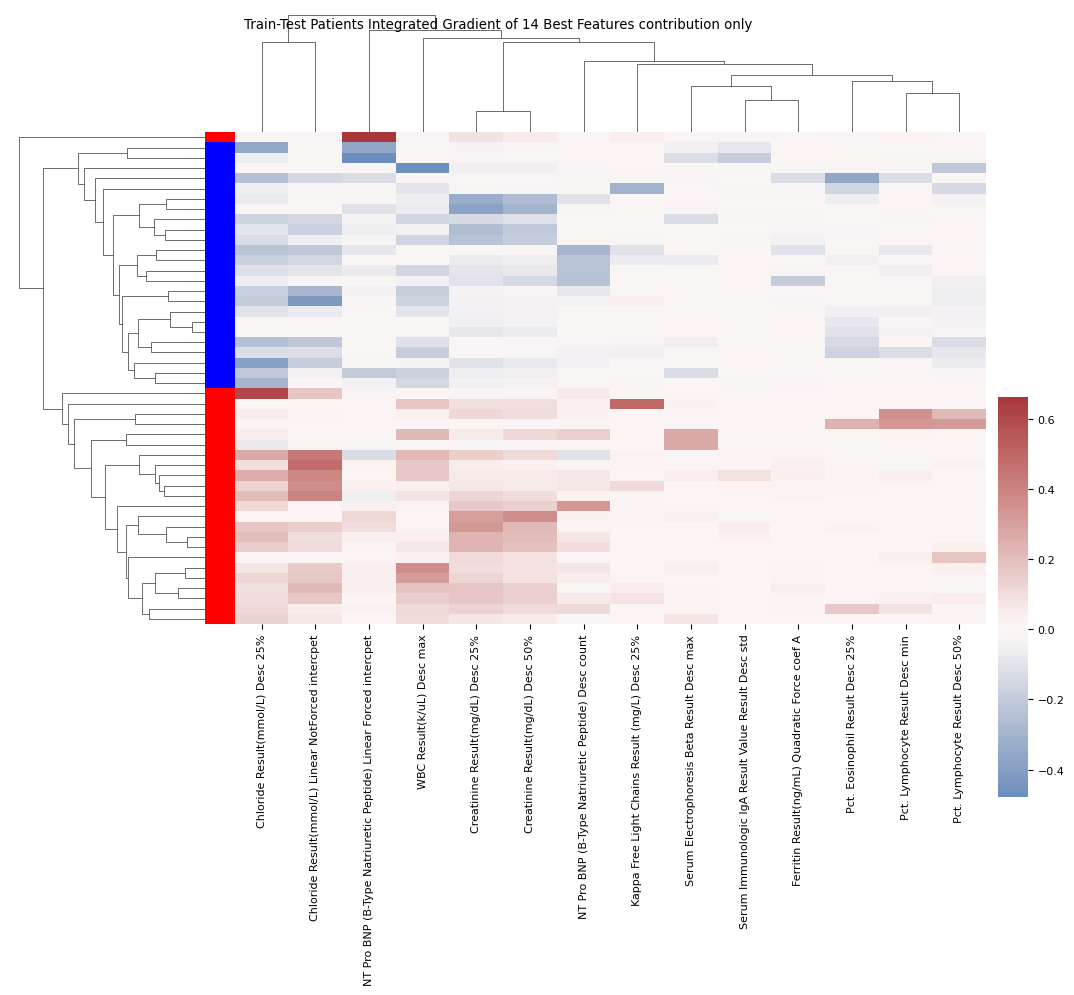

In [171]:
#integrated gradient cluster map with heigharchical clustering

IG = compute_SV_integrated_gradient(tunedModel["best_models"][fold], CV_sets_trainANDtest_X)

IGtable = pd.DataFrame(IG,columns=ListFeatureColNames)

fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=IGtable.min().min(), vmax=IGtable.max().max(), center =0, 
           #row_linkage=hcRow, col_linkage=hcCol, 
           cbar_pos=(1, .2, .03, .4),
        #    row_colors=[["red","blue"][int(l=="B")+0] for l in CV_sets[0]["test"]["y"].values]
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y])
plt.suptitle("Train-Test Patients Integrated Gradient of "+  str(numbFeatures)+ " Best Features contribution only")
plt.show()

figCommon = fileName_common + "fig4_w100"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

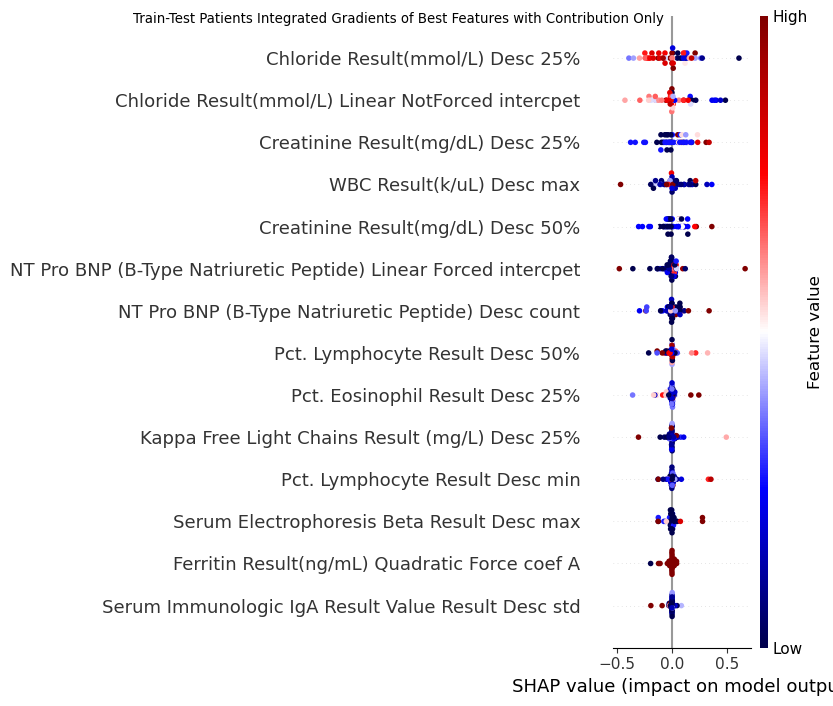

In [172]:
#shap plot for integrated gradients
fig = shap.summary_plot(IG,  CV_sets_trainANDtest_X, max_display=numbFeatures , 
                  feature_names=ListFeatureColNames,cmap="seismic", show = False)
plt.suptitle("Train-Test Patients Integrated Gradients of Best Features with Contribution Only")
figCommon = fileName_common + "fig5_w100"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')

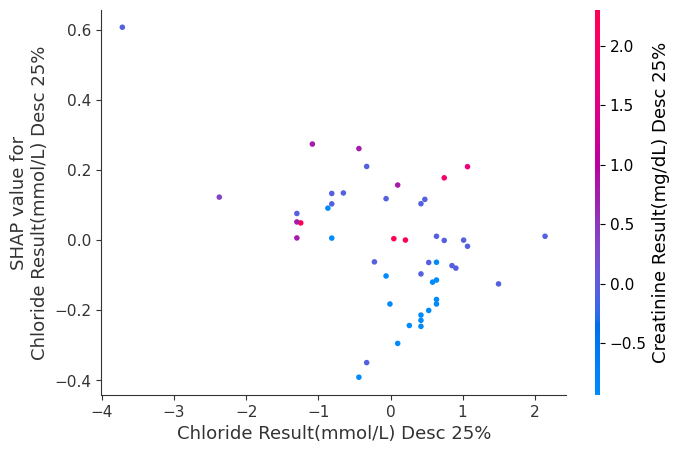

In [173]:
#shap dependence plot
Xcv = pd.DataFrame(CV_sets_trainANDtest_X, 
                     index=CV_sets_trainANDtest_y,
                     columns=ListFeatureColNames)

fig6_feature_to_plot= ListFeatureColNames[0]

shap.dependence_plot( fig6_feature_to_plot , IG, Xcv, show = False)

figCommon = fileName_common + "fig6_w100"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')

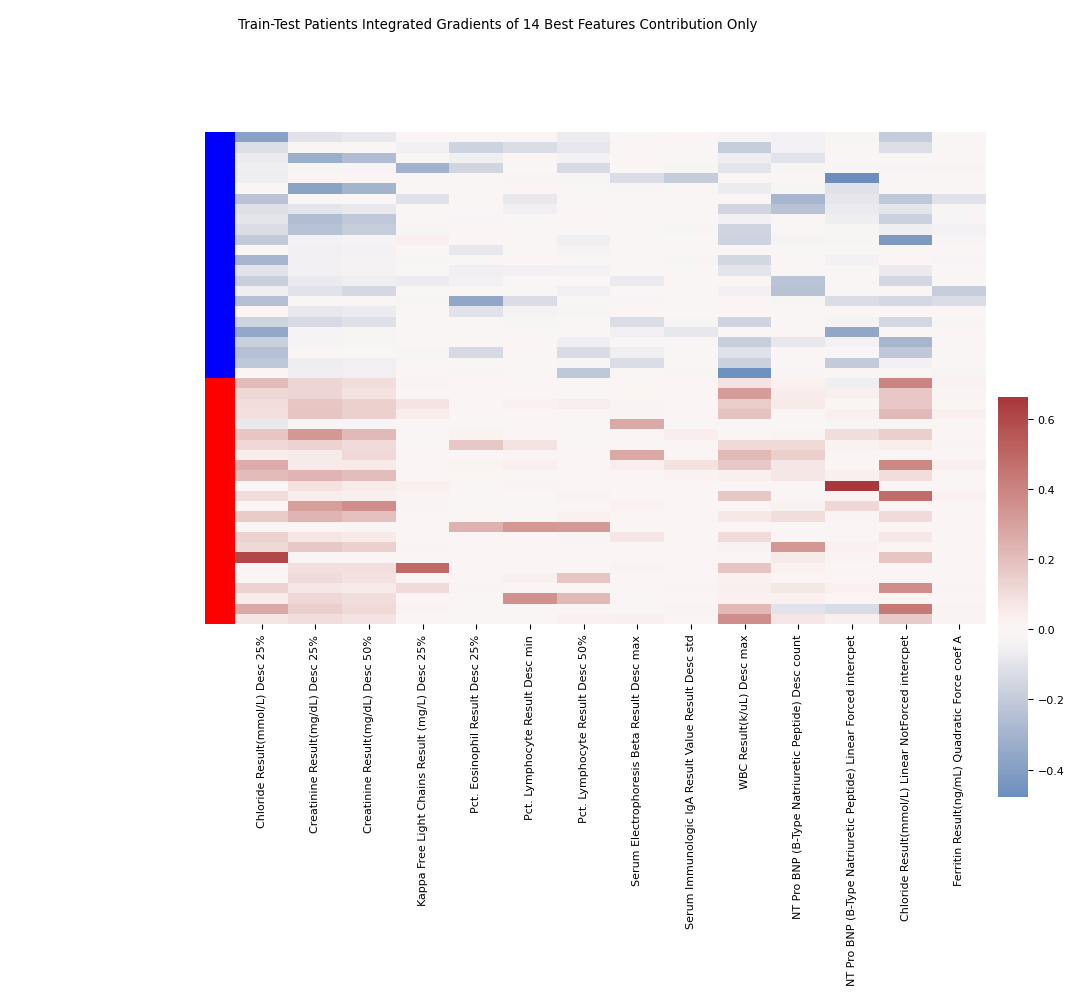

In [174]:
#cluster map of integrated gradients sorted by index
IGtable_wIndex = pd.DataFrame(IG, index=CV_sets_trainANDtest_y, columns=ListFeatureColNames)

IGtable_wIndex.reset_index(drop=True, inplace=True)
fig = clustermap(IGtable_wIndex.iloc[np.argsort(CV_sets_trainANDtest_y),:], 
           yticklabels=False,
           col_cluster=False,
           row_cluster=False,
           cmap="vlag", vmin=IGtable_wIndex.min().min(), vmax=IGtable_wIndex.max().max(), center = 0, 
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y[np.argsort(CV_sets_trainANDtest_y)]])

plt.suptitle("Train-Test Patients Integrated Gradients of "+ str(numbFeatures) +' Best Features Contribution Only')
plt.show()

figCommon = fileName_common + "fig7_w100"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

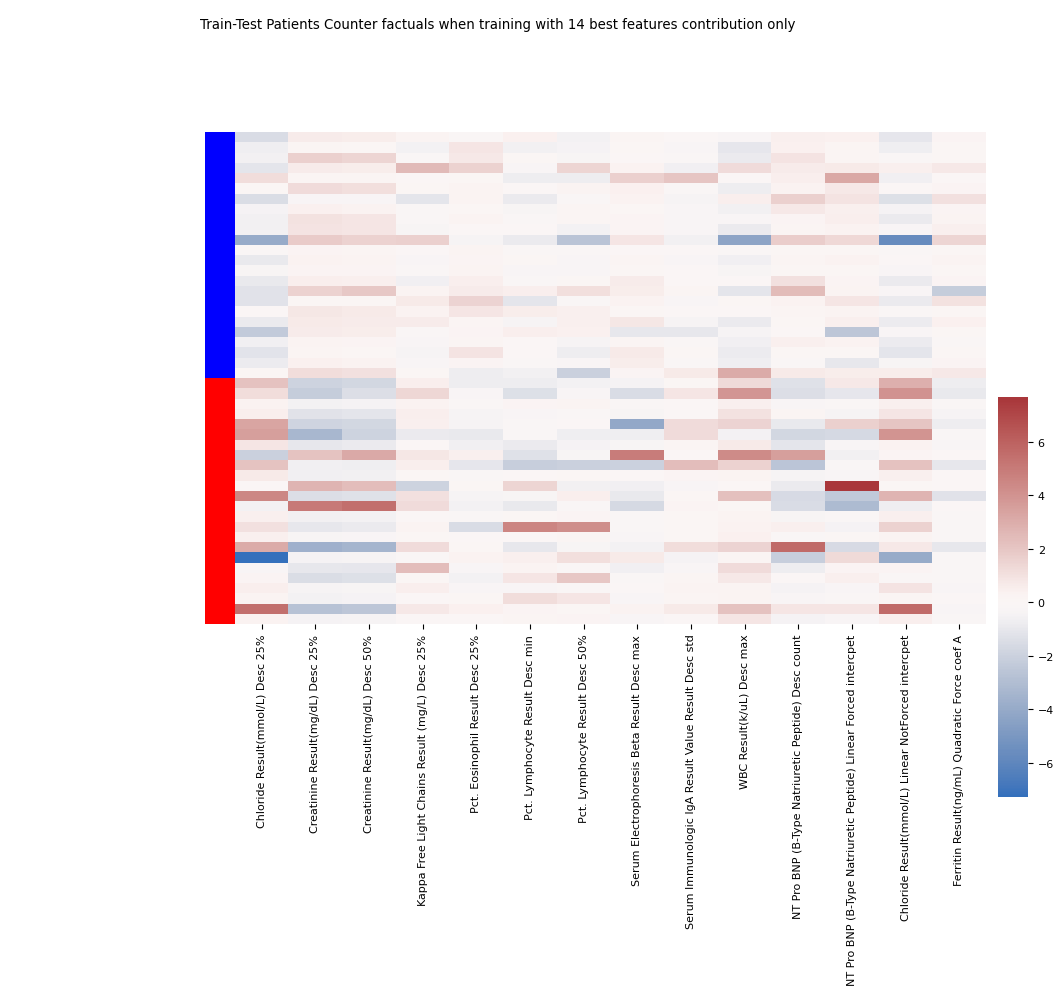

In [175]:
#counter factuals map
counterfactuals = compute_counterfactuals(tunedModel["best_models"][fold], 
                                          CV_sets_trainANDtest_X)
CFtable = pd.DataFrame(counterfactuals, 
                       index=CV_sets_trainANDtest_y,columns=ListFeatureColNames)

CFtable.reset_index(drop=True, inplace=True)
fig = clustermap(CFtable.iloc[np.argsort(CV_sets_trainANDtest_y),:],#/abs(Xtop3.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:]), 
           yticklabels=False,
           col_cluster=False,
           row_cluster=False,
           cmap="vlag", vmin=CFtable.min().min(), vmax=CFtable.max().max(), center =0,
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y[np.argsort(CV_sets_trainANDtest_y)]])
plt.suptitle("Train-Test Patients Counter factuals when training with "+ str(numbFeatures) +' best features contribution only')
# plt.show()

figCommon = fileName_common + "fig9_w100"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')